In [1]:
### Read in data from mutagenesis to begin featurization function
import pandas as pd
import re
import numpy as np
import sklearn

file = pd.read_csv("ACE2_Vals.csv")
file2 = pd.read_csv("SRBD_Vals.csv")


In [2]:
### FUNCTION TO HANDLE FEATURIZATION OF ACE2 SEQS
handle = open("Trimmed_ACE2_mammals.fasta",'r') ### 1. is pos in res num? > Is pos_res == Res? > If not, append affinity_factor
container = []
for line in handle:
    if ">" in line:
       # print(line)
        continue
    line_vector = []
    pos = 19
    ind_helper = 0
    try:
        for char in line.rstrip():
            if char == "X":
                line_vector.append(0)
                for ele in file["Res_Num"].to_list():
                    if re.fullmatch(str(pos),str(ele)):
                        ind_helper+=1
                pos+=1
                continue
            my_bool = False
            for ele in file["Res_Num"].to_list():
                if re.fullmatch(str(pos),str(ele)):
                    my_bool = True #Is pos in res num?
            if my_bool == True:
                if char == (file.loc[file['Res_Num']==pos]["Res"][ind_helper]): #Is pos_res == res?
                    line_vector.append(0)
                    ind_helper+=1
                else:
                    #print("Muty at "+str(pos))
                    line_vector.append(file.loc[file['Res_Num']==pos][char][ind_helper]) #If not, append affinity_factor
                    ind_helper+=1
            else:
                line_vector.append(0)
            pos+=1
    except:
        #print(my_bool,char,pos,ind_helper)
        raise ValueError("Oops!")
    container.append(line_vector)
handle.close()

In [3]:
### FUNCTION TO HANDLE FEATURIZATION OF SRBD SEQS // Essentially the same code as above
handle = open("RBD_repo_aligned_v2.fasta",'r') ### 1. is pos in res num? > Is pos_res == Res? > If not, append affinity_factor
container2 = []
for line in handle:
    if ">" in line:
       # print(line)
        continue
    line_vector = []
    pos = 331
    ind_helper = 0
    try:
        for char in line.rstrip():
            if char == "-":
                line_vector.append(0)
                for ele in file2["Res_Num"].to_list():
                    if re.fullmatch(str(pos),str(ele)):
                        ind_helper+=1
                pos+=1
                continue
            my_bool = False
            for ele in file2["Res_Num"].to_list():
                if re.fullmatch(str(pos),str(ele)):
                    my_bool = True #Is pos in res num?
            if my_bool == True:
                if char == (file2.loc[file2['Res_Num']==pos]["Res"][ind_helper]): #Is pos_res == res?
                    line_vector.append(0)
                    ind_helper+=1
                else:
                    #print("Muty at "+str(pos))
                    line_vector.append(file2.loc[file2['Res_Num']==pos][char][ind_helper]) #If not, append affinity_factor
                    ind_helper+=1
            else:
                line_vector.append(0)
            pos+=1
    except:
        #print(my_bool,char,pos,ind_helper)
        raise ValueError("Oops!")
    container2.append(line_vector)
handle.close()

In [5]:
z = np.zeros(shape=(203*4,701),dtype=float) ## NP.array generated, proceed to Model Input
z2 = np.zeros(shape=(203*3,701),dtype=float) ## This is not intended for use, note that the correct procedure would be to programmatically split the dataset intro training, validation, and test
z3 = np.zeros(shape=(203*2,701),dtype=float)    ## This snippet is only a proof of concept
for i in range(203):
    z[i]=np.append(container[i],container2[2])
    z2[i]=np.append(container[i],container2[1])
    z3[i]=np.append(container[i],container2[0])
for i in range(203,406):
    z[i]=np.append(container[i-203],container2[3])
    z2[i]=np.append(container[i-203],container2[5])
    z3[i]=np.append(container[i-203],container2[8])
for i in range(406,609):
    z[i]=np.append(container[i-406],container2[4])
    z2[i]=np.append(container[i-406],container2[7])
for i in range(609,812):
    z[i]=np.append(container[i-609],container2[6])
    
handle = open("labels.csv",'r')
l1,l2,l3,l4,l5,l6,l7,l8,l9 = [],[],[],[],[],[],[],[],[]
for line in handle:
    line = line.rstrip()
    store = line.split(",")
    if "Label" in line:
        continue
    l1.append(store[0]),l2.append(store[1]),l3.append(store[2]),l4.append(store[3])
    l5.append(store[4]),l6.append(store[5]),l7.append(store[6]),l8.append(store[7]),l9.append(store[8])
handle.close()
y = l3+l4+l5+l7
y = np.asarray(y,dtype=int)


In [1]:
### CREATE EXCEL SHEET DATABANK
handle = open("ACE2_S_Dataset_Mammals7.csv",'x')
handle2 = open("Trimmed_ACE2_Oneline3.fasta",'r')
for line in handle2:
    if ">" in line:
        start = line.index("[")
        end = line.index("]")
        name = line[start+1:end]
        name_store = name.split(" ")
        acc_s,acc_e = line.index(">")+1,line.index(" ")
        accession = line[acc_s:acc_e]
        gene = line[acc_e+1:start-1]
        handle.write(accession+","+name_store[0]+","+name_store[len(name_store)-1]+","+gene+"\n")
    else:
        continue
handle.close()
handle2.close()

In [3]:
#Formatting cell
handle=open("Trimmed_Aligned_ACE2_Mammals.fasta",'r')
handle2 = open("Trimmed_Aligned_ACE2_Mammals2.fasta",'x')
for line in handle:
    if ">" in line:
        start = line.index("[")
        end = line.index("]")
        name = line[start+1:end]
        name_store = name.split(" ")
        handle2.write(">"+name_store[0]+"_"+name_store[len(name_store)-1]+"_ACE2\n")
    else:
        handle2.write(line)
handle.close()
handle2.close()

In [58]:
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV

np.random.seed(8675309)

base_classifier1 = SVC(kernel="rbf", gamma=0.5, probability=True) 
base_classifier2 = RandomForestClassifier(n_estimators=250)
base_classifier3 = GaussianNB()

res1 = SelfTrainingClassifier(base_classifier1,max_iter=None).fit(z,y) #TRAINING ON TRAINING SET
res2 = SelfTrainingClassifier(base_classifier2,max_iter=None).fit(z,y) #NON-CALIBRATED
res3 = SelfTrainingClassifier(base_classifier3,max_iter=None).fit(z,y)

#res1_c = CalibratedClassifierCV(base_classifier1, cv=2, method="isotonic").fit(z,y) #CALIBRATED TRAINING. 2FOLD VALIDATION
#res2_c = CalibratedClassifierCV(base_classifier2, cv=2, method="isotonic").fit(z,y)
#res3_c = CalibratedClassifierCV(base_classifier3, cv=2, method="isotonic").fit(z,y)

In [59]:
res_out = np.round((res1.predict_proba(z)+res2.predict_proba(z)+res3.predict_proba(z))/3) #TRAIN            ###NON-CALIBRATED
res_out2 = np.round((res1.predict_proba(z2)+res2.predict_proba(z2)+res3.predict_proba(z2))/3) #VALID
res_out3 = np.round((res1.predict_proba(z3)+res2.predict_proba(z3)+res3.predict_proba(z3))/3) #TEST
list_one,list_two,list_three = [],[],[]

for ele in res_out:
    if ele[0] == 1:
        list_one.append(0)
    else:
        list_one.append(1)
for ele in res_out2:
    if ele[0] == 1:
        list_two.append(0)
    else:
        list_two.append(1)
for ele in res_out3:
    if ele[0] == 1:
        list_three.append(0)
    else:
        list_three.append(1)
        
#np.savetxt("res_1.csv",list_one,delimiter=",")
#np.savetxt("res_2.csv",list_two,delimiter=",")
#np.savetxt("res_3.csv",list_three,delimiter=",")

In [47]:
res_out_c = np.round((res1_c.predict_proba(z)+res2_c.predict_proba(z)+res3_c.predict_proba(z))/3) #TRAIN           ###CALIBRATED
res_out2_c = np.round((res1_c.predict_proba(z2)+res2_c.predict_proba(z2)+res3_c.predict_proba(z2))/3) #VALID
res_out3_c = np.round((res1_c.predict_proba(z3)+res2_c.predict_proba(z3)+res3_c.predict_proba(z3))/3) #TEST
list_one,list_two,list_three = [],[],[]
for ele in res_out_c:
    if ele[0] == 1:
        list_one.append(0)
    else:
        list_one.append(1)
for ele in res_out2_c:
    if ele[0] == 1:
        list_two.append(0)
    else:
        list_two.append(1)
for ele in res_out3_c:
    if ele[0] == 1:
        list_three.append(0)
    else:
        list_three.append(1)
np.savetxt("res_1_c.csv",list_one,delimiter=",")
np.savetxt("res_2_c.csv",list_two,delimiter=",")
np.savetxt("res_3_c.csv",list_three,delimiter=",") ### CALIBRATION SHOWS POOR PERFORMANCE, maybe it's bc of fit technique?

In [60]:
dataframe = pd.read_csv("Quality_Check.csv")           #TOTAL ACCURACY OF TRAINING + VALIDATION SET + TEST PREDICTIONS
dataframe_labelsE=dataframe.filter(regex="Label_[0-9]E").dropna(0,"all")
dataframe_labelsP=dataframe.filter(regex="Label_[0-9]P").dropna(0,"all")

#Redefine dataframe to results generated for testing quality score improvements
dataframe["Label_3P"],dataframe["Label_4P"],dataframe["Label_5P"],dataframe["Label_7P"] = list_one[0:203],list_one[203:406],list_one[406:609],list_one[609:]
dataframe["Label_2P"],dataframe["Label_6P"],dataframe["Label_8P"] = list_two[0:203],list_two[203:406],list_two[406:]
dataframe["Label_1P"],dataframe["Label_9P"] =list_three[0:203],list_three[203:]

tp, tn, fp, fn, wrong, right = 0, 0, 0, 0, 0, 0
for col in dataframe_labelsE:
    if col in ["Label_5E","Label_6E"]:
        continue
    for i in range(len(dataframe_labelsE["Label_1E"])):
        if dataframe[col][i] == -1:
            continue
        elif dataframe[col][i] == dataframe[col.replace("E","P")][i]:
            if dataframe[col][i] == 1:
                tp+=1
                right+=1
            elif dataframe[col][i] == 0:
                tn+=1
                right+=1
        else:
            if dataframe[col][i]==1:
                fn+=1
                wrong+=1
            else:
                fp+=1
                wrong+=1

precision = tp/(tp+fp)
recall = tp/(tp+fn)
accuracy = right/(right+wrong)
print("% Correct: "+ str(accuracy)+" Precision: "+ str(precision) +" Recall: "+str(recall))

% Correct: 0.9585798816568047 Precision: 0.9080459770114943 Recall: 0.9294117647058824


/tmp/ipykernel_55/3080045685.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  dataframe_labelsE=dataframe.filter(regex="Label_[0-9]E").dropna(0,"all")
/tmp/ipykernel_55/3080045685.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  dataframe_labelsP=dataframe.filter(regex="Label_[0-9]P").dropna(0,"all")


In [36]:
### Loop over and determine the most optimal number for random forest !!! 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
res_container = []
cnt=0
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV

np.random.seed(8675309)
cnt+=1

base_classifier1 = SVC(kernel="poly", gamma=0.9, probability=True) 
base_classifier2 = RandomForestClassifier(n_estimators=100)
base_classifier3 = GaussianNB()

res1 = SelfTrainingClassifier(base_classifier1,max_iter=None).fit(z,y) #TRAINING ON TRAINING SET
res2 = SelfTrainingClassifier(base_classifier2,max_iter=None).fit(z,y) #NON-CALIBRATED
res3 = SelfTrainingClassifier(base_classifier3,max_iter=None).fit(z,y)

res_out = np.round((res1.predict_proba(z)+res2.predict_proba(z)+res3.predict_proba(z))/3) #TRAIN            ###NON-CALIBRATED
res_out2 = np.round((res1.predict_proba(z2)+res2.predict_proba(z2)+res3.predict_proba(z2))/3) #VALID
res_out3 = np.round((res1.predict_proba(z3)+res2.predict_proba(z3)+res3.predict_proba(z3))/3) #TEST
list_one,list_two,list_three = [],[],[]

for ele in res_out:
    if ele[0] == 1:
        list_one.append(0)
    else:
        list_one.append(1)
for ele in res_out2:
    if ele[0] == 1:
        list_two.append(0)
    else:
        list_two.append(1)
for ele in res_out3:
    if ele[0] == 1:
        list_three.append(0)
    else:
        list_three.append(1)

dataframe = pd.read_csv("Quality_Check.csv")           #TOTAL ACCURACY OF TRAINING + VALIDATION SET + TEST PREDICTIONS
dataframe_labelsE=dataframe.filter(regex="Label_[0-9]E").dropna(0,"all")
dataframe_labelsP=dataframe.filter(regex="Label_[0-9]P").dropna(0,"all")

#Redefine dataframe to results generated for testing quality score improvements
dataframe["Label_3P"],dataframe["Label_4P"],dataframe["Label_5P"],dataframe["Label_7P"] = list_one[0:203],list_one[203:406],list_one[406:609],list_one[609:]
dataframe["Label_2P"],dataframe["Label_6P"],dataframe["Label_8P"] = list_two[0:203],list_two[203:406],list_two[406:]
dataframe["Label_1P"],dataframe["Label_9P"] =list_three[0:203],list_three[203:]

tp, tn, fp, fn, wrong, right = 0, 0, 0, 0, 0, 0
for col in dataframe_labelsE:
    #if col in ["Label_5E","Label_6E"]:
        #continue
    for i in range(len(dataframe_labelsE["Label_1E"])):
        if dataframe[col][i] == -1:
            continue
        elif dataframe[col][i] == dataframe[col.replace("E","P")][i]:
            if dataframe[col][i] == 1:
                tp+=1
                right+=1
            elif dataframe[col][i] == 0:
                tn+=1
                right+=1
        else:
            if dataframe[col][i]==1:
                fn+=1
                wrong+=1
            else:
                fp+=1
                wrong+=1

precision = tp/(tp+fp)
recall = tp/(tp+fn)
accuracy = right/(right+wrong)
bundle = [accuracy,precision,recall]
res_container.append(bundle)
print("Finished iteration "+str(cnt))

Finished iteration 1


In [37]:
print(bundle)

[0.9185232336091661, 0.8655616942909761, 0.8952380952380953]


Finished iteration 1 at GAMMA: 0.005 ---- Trees = 5
Finished iteration 2 at GAMMA: 0.01 ---- Trees = 5
Finished iteration 3 at GAMMA: 0.015 ---- Trees = 5
Finished iteration 4 at GAMMA: 0.02 ---- Trees = 5
Finished iteration 5 at GAMMA: 0.025 ---- Trees = 5
Finished iteration 6 at GAMMA: 0.03 ---- Trees = 5
Finished iteration 7 at GAMMA: 0.035 ---- Trees = 5
Finished iteration 8 at GAMMA: 0.04 ---- Trees = 5
Finished iteration 9 at GAMMA: 0.045 ---- Trees = 5
Finished iteration 10 at GAMMA: 0.05 ---- Trees = 5
Finished iteration 11 at GAMMA: 0.055 ---- Trees = 5
Finished iteration 12 at GAMMA: 0.06 ---- Trees = 5
Finished iteration 13 at GAMMA: 0.065 ---- Trees = 5
Finished iteration 14 at GAMMA: 0.07 ---- Trees = 5
Finished iteration 15 at GAMMA: 0.075 ---- Trees = 5
Finished iteration 16 at GAMMA: 0.08 ---- Trees = 5
Finished iteration 17 at GAMMA: 0.085 ---- Trees = 5
Finished iteration 18 at GAMMA: 0.09 ---- Trees = 5
Finished iteration 19 at GAMMA: 0.095 ---- Trees = 5
Finished it

Finished iteration 153 at GAMMA: 0.765 ---- Trees = 5
Finished iteration 154 at GAMMA: 0.77 ---- Trees = 5
Finished iteration 155 at GAMMA: 0.775 ---- Trees = 5
Finished iteration 156 at GAMMA: 0.78 ---- Trees = 5
Finished iteration 157 at GAMMA: 0.785 ---- Trees = 5
Finished iteration 158 at GAMMA: 0.79 ---- Trees = 5
Finished iteration 159 at GAMMA: 0.795 ---- Trees = 5
Finished iteration 160 at GAMMA: 0.8 ---- Trees = 5
Finished iteration 161 at GAMMA: 0.805 ---- Trees = 5
Finished iteration 162 at GAMMA: 0.81 ---- Trees = 5
Finished iteration 163 at GAMMA: 0.8150000000000001 ---- Trees = 5
Finished iteration 164 at GAMMA: 0.8200000000000001 ---- Trees = 5
Finished iteration 165 at GAMMA: 0.8250000000000001 ---- Trees = 5
Finished iteration 166 at GAMMA: 0.8300000000000001 ---- Trees = 5
Finished iteration 167 at GAMMA: 0.835 ---- Trees = 5
Finished iteration 168 at GAMMA: 0.84 ---- Trees = 5
Finished iteration 169 at GAMMA: 0.845 ---- Trees = 5
Finished iteration 170 at GAMMA: 0.85

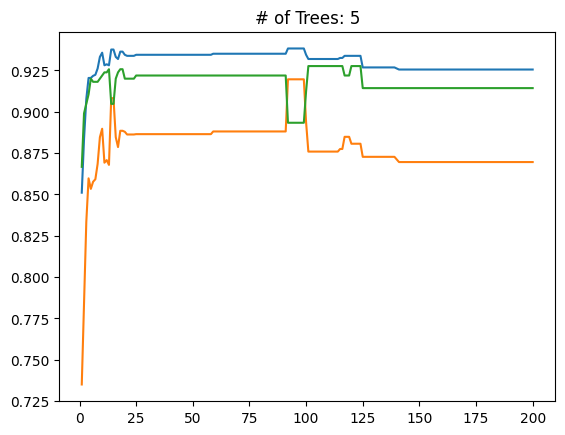

Finished iteration 1 at GAMMA: 0.005 ---- Trees = 10
Finished iteration 2 at GAMMA: 0.01 ---- Trees = 10
Finished iteration 3 at GAMMA: 0.015 ---- Trees = 10
Finished iteration 4 at GAMMA: 0.02 ---- Trees = 10
Finished iteration 5 at GAMMA: 0.025 ---- Trees = 10
Finished iteration 6 at GAMMA: 0.03 ---- Trees = 10
Finished iteration 7 at GAMMA: 0.035 ---- Trees = 10
Finished iteration 8 at GAMMA: 0.04 ---- Trees = 10
Finished iteration 9 at GAMMA: 0.045 ---- Trees = 10
Finished iteration 10 at GAMMA: 0.05 ---- Trees = 10
Finished iteration 11 at GAMMA: 0.055 ---- Trees = 10
Finished iteration 12 at GAMMA: 0.06 ---- Trees = 10
Finished iteration 13 at GAMMA: 0.065 ---- Trees = 10
Finished iteration 14 at GAMMA: 0.07 ---- Trees = 10
Finished iteration 15 at GAMMA: 0.075 ---- Trees = 10
Finished iteration 16 at GAMMA: 0.08 ---- Trees = 10
Finished iteration 17 at GAMMA: 0.085 ---- Trees = 10
Finished iteration 18 at GAMMA: 0.09 ---- Trees = 10
Finished iteration 19 at GAMMA: 0.095 ---- Tre

Finished iteration 150 at GAMMA: 0.75 ---- Trees = 10
Finished iteration 151 at GAMMA: 0.755 ---- Trees = 10
Finished iteration 152 at GAMMA: 0.76 ---- Trees = 10
Finished iteration 153 at GAMMA: 0.765 ---- Trees = 10
Finished iteration 154 at GAMMA: 0.77 ---- Trees = 10
Finished iteration 155 at GAMMA: 0.775 ---- Trees = 10
Finished iteration 156 at GAMMA: 0.78 ---- Trees = 10
Finished iteration 157 at GAMMA: 0.785 ---- Trees = 10
Finished iteration 158 at GAMMA: 0.79 ---- Trees = 10
Finished iteration 159 at GAMMA: 0.795 ---- Trees = 10
Finished iteration 160 at GAMMA: 0.8 ---- Trees = 10
Finished iteration 161 at GAMMA: 0.805 ---- Trees = 10
Finished iteration 162 at GAMMA: 0.81 ---- Trees = 10
Finished iteration 163 at GAMMA: 0.8150000000000001 ---- Trees = 10
Finished iteration 164 at GAMMA: 0.8200000000000001 ---- Trees = 10
Finished iteration 165 at GAMMA: 0.8250000000000001 ---- Trees = 10
Finished iteration 166 at GAMMA: 0.8300000000000001 ---- Trees = 10
Finished iteration 16

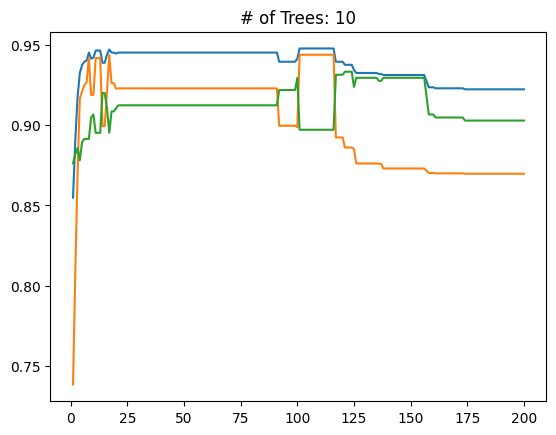

Finished iteration 1 at GAMMA: 0.005 ---- Trees = 15
Finished iteration 2 at GAMMA: 0.01 ---- Trees = 15
Finished iteration 3 at GAMMA: 0.015 ---- Trees = 15
Finished iteration 4 at GAMMA: 0.02 ---- Trees = 15
Finished iteration 5 at GAMMA: 0.025 ---- Trees = 15
Finished iteration 6 at GAMMA: 0.03 ---- Trees = 15
Finished iteration 7 at GAMMA: 0.035 ---- Trees = 15
Finished iteration 8 at GAMMA: 0.04 ---- Trees = 15
Finished iteration 9 at GAMMA: 0.045 ---- Trees = 15
Finished iteration 10 at GAMMA: 0.05 ---- Trees = 15
Finished iteration 11 at GAMMA: 0.055 ---- Trees = 15
Finished iteration 12 at GAMMA: 0.06 ---- Trees = 15
Finished iteration 13 at GAMMA: 0.065 ---- Trees = 15
Finished iteration 14 at GAMMA: 0.07 ---- Trees = 15
Finished iteration 15 at GAMMA: 0.075 ---- Trees = 15
Finished iteration 16 at GAMMA: 0.08 ---- Trees = 15
Finished iteration 17 at GAMMA: 0.085 ---- Trees = 15
Finished iteration 18 at GAMMA: 0.09 ---- Trees = 15
Finished iteration 19 at GAMMA: 0.095 ---- Tre

Finished iteration 150 at GAMMA: 0.75 ---- Trees = 15
Finished iteration 151 at GAMMA: 0.755 ---- Trees = 15
Finished iteration 152 at GAMMA: 0.76 ---- Trees = 15
Finished iteration 153 at GAMMA: 0.765 ---- Trees = 15
Finished iteration 154 at GAMMA: 0.77 ---- Trees = 15
Finished iteration 155 at GAMMA: 0.775 ---- Trees = 15
Finished iteration 156 at GAMMA: 0.78 ---- Trees = 15
Finished iteration 157 at GAMMA: 0.785 ---- Trees = 15
Finished iteration 158 at GAMMA: 0.79 ---- Trees = 15
Finished iteration 159 at GAMMA: 0.795 ---- Trees = 15
Finished iteration 160 at GAMMA: 0.8 ---- Trees = 15
Finished iteration 161 at GAMMA: 0.805 ---- Trees = 15
Finished iteration 162 at GAMMA: 0.81 ---- Trees = 15
Finished iteration 163 at GAMMA: 0.8150000000000001 ---- Trees = 15
Finished iteration 164 at GAMMA: 0.8200000000000001 ---- Trees = 15
Finished iteration 165 at GAMMA: 0.8250000000000001 ---- Trees = 15
Finished iteration 166 at GAMMA: 0.8300000000000001 ---- Trees = 15
Finished iteration 16

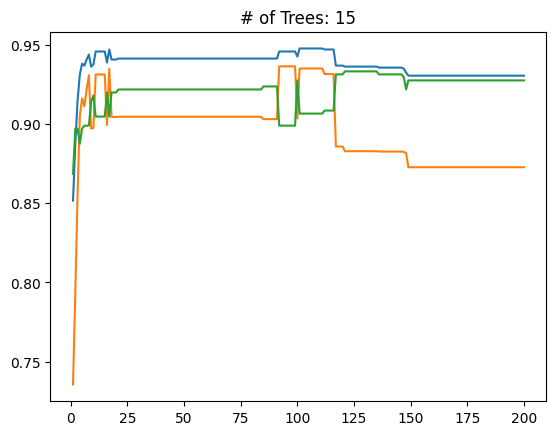

Finished iteration 1 at GAMMA: 0.005 ---- Trees = 20
Finished iteration 2 at GAMMA: 0.01 ---- Trees = 20
Finished iteration 3 at GAMMA: 0.015 ---- Trees = 20
Finished iteration 4 at GAMMA: 0.02 ---- Trees = 20
Finished iteration 5 at GAMMA: 0.025 ---- Trees = 20
Finished iteration 6 at GAMMA: 0.03 ---- Trees = 20
Finished iteration 7 at GAMMA: 0.035 ---- Trees = 20
Finished iteration 8 at GAMMA: 0.04 ---- Trees = 20
Finished iteration 9 at GAMMA: 0.045 ---- Trees = 20
Finished iteration 10 at GAMMA: 0.05 ---- Trees = 20
Finished iteration 11 at GAMMA: 0.055 ---- Trees = 20
Finished iteration 12 at GAMMA: 0.06 ---- Trees = 20
Finished iteration 13 at GAMMA: 0.065 ---- Trees = 20
Finished iteration 14 at GAMMA: 0.07 ---- Trees = 20
Finished iteration 15 at GAMMA: 0.075 ---- Trees = 20
Finished iteration 16 at GAMMA: 0.08 ---- Trees = 20
Finished iteration 17 at GAMMA: 0.085 ---- Trees = 20
Finished iteration 18 at GAMMA: 0.09 ---- Trees = 20
Finished iteration 19 at GAMMA: 0.095 ---- Tre

Finished iteration 150 at GAMMA: 0.75 ---- Trees = 20
Finished iteration 151 at GAMMA: 0.755 ---- Trees = 20
Finished iteration 152 at GAMMA: 0.76 ---- Trees = 20
Finished iteration 153 at GAMMA: 0.765 ---- Trees = 20
Finished iteration 154 at GAMMA: 0.77 ---- Trees = 20
Finished iteration 155 at GAMMA: 0.775 ---- Trees = 20
Finished iteration 156 at GAMMA: 0.78 ---- Trees = 20
Finished iteration 157 at GAMMA: 0.785 ---- Trees = 20
Finished iteration 158 at GAMMA: 0.79 ---- Trees = 20
Finished iteration 159 at GAMMA: 0.795 ---- Trees = 20
Finished iteration 160 at GAMMA: 0.8 ---- Trees = 20
Finished iteration 161 at GAMMA: 0.805 ---- Trees = 20
Finished iteration 162 at GAMMA: 0.81 ---- Trees = 20
Finished iteration 163 at GAMMA: 0.8150000000000001 ---- Trees = 20
Finished iteration 164 at GAMMA: 0.8200000000000001 ---- Trees = 20
Finished iteration 165 at GAMMA: 0.8250000000000001 ---- Trees = 20
Finished iteration 166 at GAMMA: 0.8300000000000001 ---- Trees = 20
Finished iteration 16

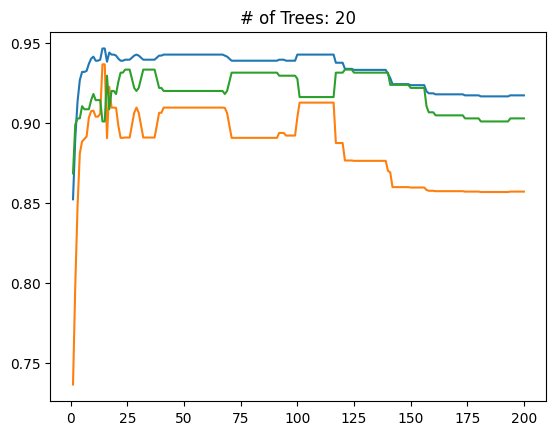

Finished iteration 1 at GAMMA: 0.005 ---- Trees = 25
Finished iteration 2 at GAMMA: 0.01 ---- Trees = 25
Finished iteration 3 at GAMMA: 0.015 ---- Trees = 25
Finished iteration 4 at GAMMA: 0.02 ---- Trees = 25
Finished iteration 5 at GAMMA: 0.025 ---- Trees = 25
Finished iteration 6 at GAMMA: 0.03 ---- Trees = 25
Finished iteration 7 at GAMMA: 0.035 ---- Trees = 25
Finished iteration 8 at GAMMA: 0.04 ---- Trees = 25
Finished iteration 9 at GAMMA: 0.045 ---- Trees = 25
Finished iteration 10 at GAMMA: 0.05 ---- Trees = 25
Finished iteration 11 at GAMMA: 0.055 ---- Trees = 25
Finished iteration 12 at GAMMA: 0.06 ---- Trees = 25
Finished iteration 13 at GAMMA: 0.065 ---- Trees = 25
Finished iteration 14 at GAMMA: 0.07 ---- Trees = 25
Finished iteration 15 at GAMMA: 0.075 ---- Trees = 25
Finished iteration 16 at GAMMA: 0.08 ---- Trees = 25
Finished iteration 17 at GAMMA: 0.085 ---- Trees = 25
Finished iteration 18 at GAMMA: 0.09 ---- Trees = 25
Finished iteration 19 at GAMMA: 0.095 ---- Tre

Finished iteration 150 at GAMMA: 0.75 ---- Trees = 25
Finished iteration 151 at GAMMA: 0.755 ---- Trees = 25
Finished iteration 152 at GAMMA: 0.76 ---- Trees = 25
Finished iteration 153 at GAMMA: 0.765 ---- Trees = 25
Finished iteration 154 at GAMMA: 0.77 ---- Trees = 25
Finished iteration 155 at GAMMA: 0.775 ---- Trees = 25
Finished iteration 156 at GAMMA: 0.78 ---- Trees = 25
Finished iteration 157 at GAMMA: 0.785 ---- Trees = 25
Finished iteration 158 at GAMMA: 0.79 ---- Trees = 25
Finished iteration 159 at GAMMA: 0.795 ---- Trees = 25
Finished iteration 160 at GAMMA: 0.8 ---- Trees = 25
Finished iteration 161 at GAMMA: 0.805 ---- Trees = 25
Finished iteration 162 at GAMMA: 0.81 ---- Trees = 25
Finished iteration 163 at GAMMA: 0.8150000000000001 ---- Trees = 25
Finished iteration 164 at GAMMA: 0.8200000000000001 ---- Trees = 25
Finished iteration 165 at GAMMA: 0.8250000000000001 ---- Trees = 25
Finished iteration 166 at GAMMA: 0.8300000000000001 ---- Trees = 25
Finished iteration 16

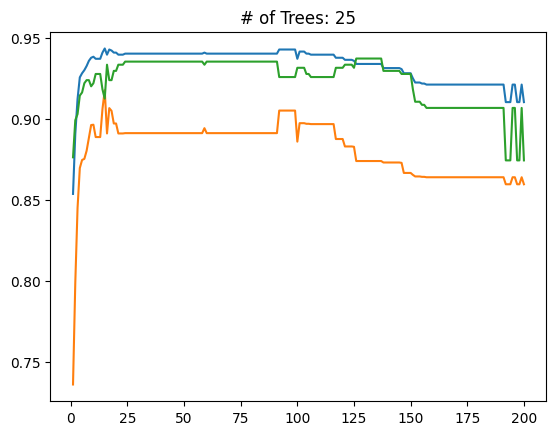

Finished iteration 1 at GAMMA: 0.005 ---- Trees = 30
Finished iteration 2 at GAMMA: 0.01 ---- Trees = 30
Finished iteration 3 at GAMMA: 0.015 ---- Trees = 30
Finished iteration 4 at GAMMA: 0.02 ---- Trees = 30
Finished iteration 5 at GAMMA: 0.025 ---- Trees = 30
Finished iteration 6 at GAMMA: 0.03 ---- Trees = 30
Finished iteration 7 at GAMMA: 0.035 ---- Trees = 30
Finished iteration 8 at GAMMA: 0.04 ---- Trees = 30
Finished iteration 9 at GAMMA: 0.045 ---- Trees = 30
Finished iteration 10 at GAMMA: 0.05 ---- Trees = 30
Finished iteration 11 at GAMMA: 0.055 ---- Trees = 30
Finished iteration 12 at GAMMA: 0.06 ---- Trees = 30
Finished iteration 13 at GAMMA: 0.065 ---- Trees = 30
Finished iteration 14 at GAMMA: 0.07 ---- Trees = 30
Finished iteration 15 at GAMMA: 0.075 ---- Trees = 30
Finished iteration 16 at GAMMA: 0.08 ---- Trees = 30
Finished iteration 17 at GAMMA: 0.085 ---- Trees = 30
Finished iteration 18 at GAMMA: 0.09 ---- Trees = 30
Finished iteration 19 at GAMMA: 0.095 ---- Tre

Finished iteration 150 at GAMMA: 0.75 ---- Trees = 30
Finished iteration 151 at GAMMA: 0.755 ---- Trees = 30
Finished iteration 152 at GAMMA: 0.76 ---- Trees = 30
Finished iteration 153 at GAMMA: 0.765 ---- Trees = 30
Finished iteration 154 at GAMMA: 0.77 ---- Trees = 30
Finished iteration 155 at GAMMA: 0.775 ---- Trees = 30
Finished iteration 156 at GAMMA: 0.78 ---- Trees = 30
Finished iteration 157 at GAMMA: 0.785 ---- Trees = 30
Finished iteration 158 at GAMMA: 0.79 ---- Trees = 30
Finished iteration 159 at GAMMA: 0.795 ---- Trees = 30
Finished iteration 160 at GAMMA: 0.8 ---- Trees = 30
Finished iteration 161 at GAMMA: 0.805 ---- Trees = 30
Finished iteration 162 at GAMMA: 0.81 ---- Trees = 30
Finished iteration 163 at GAMMA: 0.8150000000000001 ---- Trees = 30
Finished iteration 164 at GAMMA: 0.8200000000000001 ---- Trees = 30
Finished iteration 165 at GAMMA: 0.8250000000000001 ---- Trees = 30
Finished iteration 166 at GAMMA: 0.8300000000000001 ---- Trees = 30
Finished iteration 16

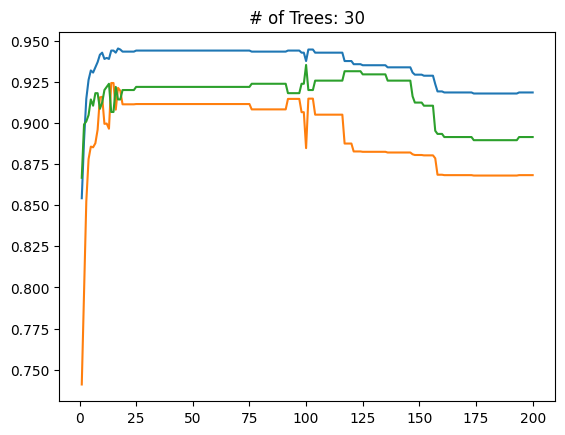

Finished iteration 1 at GAMMA: 0.005 ---- Trees = 35
Finished iteration 2 at GAMMA: 0.01 ---- Trees = 35
Finished iteration 3 at GAMMA: 0.015 ---- Trees = 35
Finished iteration 4 at GAMMA: 0.02 ---- Trees = 35
Finished iteration 5 at GAMMA: 0.025 ---- Trees = 35
Finished iteration 6 at GAMMA: 0.03 ---- Trees = 35
Finished iteration 7 at GAMMA: 0.035 ---- Trees = 35
Finished iteration 8 at GAMMA: 0.04 ---- Trees = 35
Finished iteration 9 at GAMMA: 0.045 ---- Trees = 35
Finished iteration 10 at GAMMA: 0.05 ---- Trees = 35
Finished iteration 11 at GAMMA: 0.055 ---- Trees = 35
Finished iteration 12 at GAMMA: 0.06 ---- Trees = 35
Finished iteration 13 at GAMMA: 0.065 ---- Trees = 35
Finished iteration 14 at GAMMA: 0.07 ---- Trees = 35
Finished iteration 15 at GAMMA: 0.075 ---- Trees = 35
Finished iteration 16 at GAMMA: 0.08 ---- Trees = 35
Finished iteration 17 at GAMMA: 0.085 ---- Trees = 35
Finished iteration 18 at GAMMA: 0.09 ---- Trees = 35
Finished iteration 19 at GAMMA: 0.095 ---- Tre

Finished iteration 150 at GAMMA: 0.75 ---- Trees = 35
Finished iteration 151 at GAMMA: 0.755 ---- Trees = 35
Finished iteration 152 at GAMMA: 0.76 ---- Trees = 35
Finished iteration 153 at GAMMA: 0.765 ---- Trees = 35
Finished iteration 154 at GAMMA: 0.77 ---- Trees = 35
Finished iteration 155 at GAMMA: 0.775 ---- Trees = 35
Finished iteration 156 at GAMMA: 0.78 ---- Trees = 35
Finished iteration 157 at GAMMA: 0.785 ---- Trees = 35
Finished iteration 158 at GAMMA: 0.79 ---- Trees = 35
Finished iteration 159 at GAMMA: 0.795 ---- Trees = 35
Finished iteration 160 at GAMMA: 0.8 ---- Trees = 35
Finished iteration 161 at GAMMA: 0.805 ---- Trees = 35
Finished iteration 162 at GAMMA: 0.81 ---- Trees = 35
Finished iteration 163 at GAMMA: 0.8150000000000001 ---- Trees = 35
Finished iteration 164 at GAMMA: 0.8200000000000001 ---- Trees = 35
Finished iteration 165 at GAMMA: 0.8250000000000001 ---- Trees = 35
Finished iteration 166 at GAMMA: 0.8300000000000001 ---- Trees = 35
Finished iteration 16

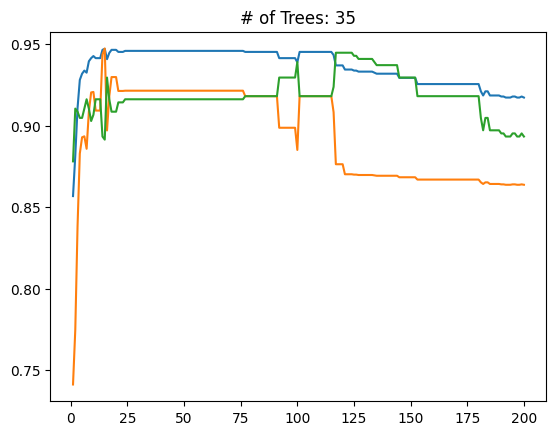

Finished iteration 1 at GAMMA: 0.005 ---- Trees = 40
Finished iteration 2 at GAMMA: 0.01 ---- Trees = 40
Finished iteration 3 at GAMMA: 0.015 ---- Trees = 40
Finished iteration 4 at GAMMA: 0.02 ---- Trees = 40
Finished iteration 5 at GAMMA: 0.025 ---- Trees = 40
Finished iteration 6 at GAMMA: 0.03 ---- Trees = 40
Finished iteration 7 at GAMMA: 0.035 ---- Trees = 40
Finished iteration 8 at GAMMA: 0.04 ---- Trees = 40
Finished iteration 9 at GAMMA: 0.045 ---- Trees = 40
Finished iteration 10 at GAMMA: 0.05 ---- Trees = 40
Finished iteration 11 at GAMMA: 0.055 ---- Trees = 40
Finished iteration 12 at GAMMA: 0.06 ---- Trees = 40
Finished iteration 13 at GAMMA: 0.065 ---- Trees = 40
Finished iteration 14 at GAMMA: 0.07 ---- Trees = 40
Finished iteration 15 at GAMMA: 0.075 ---- Trees = 40
Finished iteration 16 at GAMMA: 0.08 ---- Trees = 40
Finished iteration 17 at GAMMA: 0.085 ---- Trees = 40
Finished iteration 18 at GAMMA: 0.09 ---- Trees = 40
Finished iteration 19 at GAMMA: 0.095 ---- Tre

Finished iteration 150 at GAMMA: 0.75 ---- Trees = 40
Finished iteration 151 at GAMMA: 0.755 ---- Trees = 40
Finished iteration 152 at GAMMA: 0.76 ---- Trees = 40
Finished iteration 153 at GAMMA: 0.765 ---- Trees = 40
Finished iteration 154 at GAMMA: 0.77 ---- Trees = 40
Finished iteration 155 at GAMMA: 0.775 ---- Trees = 40
Finished iteration 156 at GAMMA: 0.78 ---- Trees = 40
Finished iteration 157 at GAMMA: 0.785 ---- Trees = 40
Finished iteration 158 at GAMMA: 0.79 ---- Trees = 40
Finished iteration 159 at GAMMA: 0.795 ---- Trees = 40
Finished iteration 160 at GAMMA: 0.8 ---- Trees = 40
Finished iteration 161 at GAMMA: 0.805 ---- Trees = 40
Finished iteration 162 at GAMMA: 0.81 ---- Trees = 40
Finished iteration 163 at GAMMA: 0.8150000000000001 ---- Trees = 40
Finished iteration 164 at GAMMA: 0.8200000000000001 ---- Trees = 40
Finished iteration 165 at GAMMA: 0.8250000000000001 ---- Trees = 40
Finished iteration 166 at GAMMA: 0.8300000000000001 ---- Trees = 40
Finished iteration 16

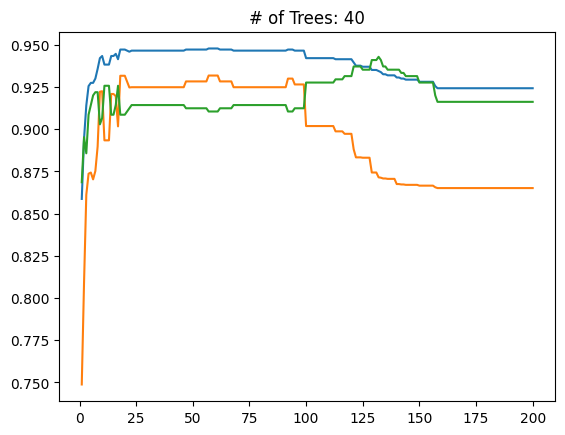

Finished iteration 1 at GAMMA: 0.005 ---- Trees = 45
Finished iteration 2 at GAMMA: 0.01 ---- Trees = 45
Finished iteration 3 at GAMMA: 0.015 ---- Trees = 45
Finished iteration 4 at GAMMA: 0.02 ---- Trees = 45
Finished iteration 5 at GAMMA: 0.025 ---- Trees = 45
Finished iteration 6 at GAMMA: 0.03 ---- Trees = 45
Finished iteration 7 at GAMMA: 0.035 ---- Trees = 45
Finished iteration 8 at GAMMA: 0.04 ---- Trees = 45
Finished iteration 9 at GAMMA: 0.045 ---- Trees = 45
Finished iteration 10 at GAMMA: 0.05 ---- Trees = 45
Finished iteration 11 at GAMMA: 0.055 ---- Trees = 45
Finished iteration 12 at GAMMA: 0.06 ---- Trees = 45
Finished iteration 13 at GAMMA: 0.065 ---- Trees = 45
Finished iteration 14 at GAMMA: 0.07 ---- Trees = 45
Finished iteration 15 at GAMMA: 0.075 ---- Trees = 45
Finished iteration 16 at GAMMA: 0.08 ---- Trees = 45
Finished iteration 17 at GAMMA: 0.085 ---- Trees = 45
Finished iteration 18 at GAMMA: 0.09 ---- Trees = 45
Finished iteration 19 at GAMMA: 0.095 ---- Tre

Finished iteration 150 at GAMMA: 0.75 ---- Trees = 45
Finished iteration 151 at GAMMA: 0.755 ---- Trees = 45
Finished iteration 152 at GAMMA: 0.76 ---- Trees = 45
Finished iteration 153 at GAMMA: 0.765 ---- Trees = 45
Finished iteration 154 at GAMMA: 0.77 ---- Trees = 45
Finished iteration 155 at GAMMA: 0.775 ---- Trees = 45
Finished iteration 156 at GAMMA: 0.78 ---- Trees = 45
Finished iteration 157 at GAMMA: 0.785 ---- Trees = 45
Finished iteration 158 at GAMMA: 0.79 ---- Trees = 45
Finished iteration 159 at GAMMA: 0.795 ---- Trees = 45
Finished iteration 160 at GAMMA: 0.8 ---- Trees = 45
Finished iteration 161 at GAMMA: 0.805 ---- Trees = 45
Finished iteration 162 at GAMMA: 0.81 ---- Trees = 45
Finished iteration 163 at GAMMA: 0.8150000000000001 ---- Trees = 45
Finished iteration 164 at GAMMA: 0.8200000000000001 ---- Trees = 45
Finished iteration 165 at GAMMA: 0.8250000000000001 ---- Trees = 45
Finished iteration 166 at GAMMA: 0.8300000000000001 ---- Trees = 45
Finished iteration 16

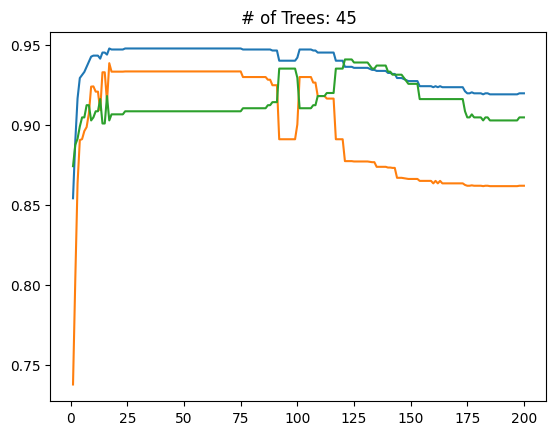

Finished iteration 1 at GAMMA: 0.005 ---- Trees = 50
Finished iteration 2 at GAMMA: 0.01 ---- Trees = 50
Finished iteration 3 at GAMMA: 0.015 ---- Trees = 50
Finished iteration 4 at GAMMA: 0.02 ---- Trees = 50
Finished iteration 5 at GAMMA: 0.025 ---- Trees = 50
Finished iteration 6 at GAMMA: 0.03 ---- Trees = 50
Finished iteration 7 at GAMMA: 0.035 ---- Trees = 50
Finished iteration 8 at GAMMA: 0.04 ---- Trees = 50
Finished iteration 9 at GAMMA: 0.045 ---- Trees = 50
Finished iteration 10 at GAMMA: 0.05 ---- Trees = 50
Finished iteration 11 at GAMMA: 0.055 ---- Trees = 50
Finished iteration 12 at GAMMA: 0.06 ---- Trees = 50
Finished iteration 13 at GAMMA: 0.065 ---- Trees = 50
Finished iteration 14 at GAMMA: 0.07 ---- Trees = 50
Finished iteration 15 at GAMMA: 0.075 ---- Trees = 50
Finished iteration 16 at GAMMA: 0.08 ---- Trees = 50
Finished iteration 17 at GAMMA: 0.085 ---- Trees = 50
Finished iteration 18 at GAMMA: 0.09 ---- Trees = 50
Finished iteration 19 at GAMMA: 0.095 ---- Tre

Finished iteration 150 at GAMMA: 0.75 ---- Trees = 50
Finished iteration 151 at GAMMA: 0.755 ---- Trees = 50
Finished iteration 152 at GAMMA: 0.76 ---- Trees = 50
Finished iteration 153 at GAMMA: 0.765 ---- Trees = 50
Finished iteration 154 at GAMMA: 0.77 ---- Trees = 50
Finished iteration 155 at GAMMA: 0.775 ---- Trees = 50
Finished iteration 156 at GAMMA: 0.78 ---- Trees = 50
Finished iteration 157 at GAMMA: 0.785 ---- Trees = 50
Finished iteration 158 at GAMMA: 0.79 ---- Trees = 50
Finished iteration 159 at GAMMA: 0.795 ---- Trees = 50
Finished iteration 160 at GAMMA: 0.8 ---- Trees = 50
Finished iteration 161 at GAMMA: 0.805 ---- Trees = 50
Finished iteration 162 at GAMMA: 0.81 ---- Trees = 50
Finished iteration 163 at GAMMA: 0.8150000000000001 ---- Trees = 50
Finished iteration 164 at GAMMA: 0.8200000000000001 ---- Trees = 50
Finished iteration 165 at GAMMA: 0.8250000000000001 ---- Trees = 50
Finished iteration 166 at GAMMA: 0.8300000000000001 ---- Trees = 50
Finished iteration 16

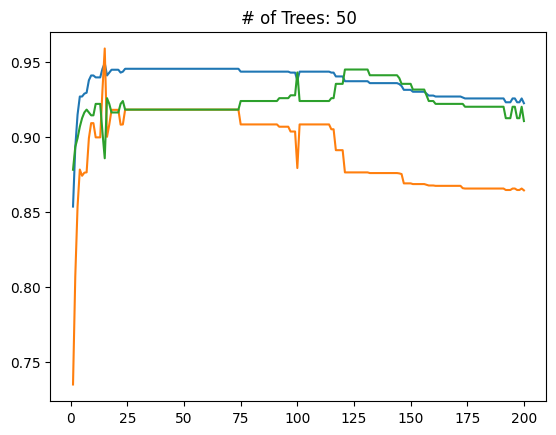

Finished iteration 1 at GAMMA: 0.005 ---- Trees = 55
Finished iteration 2 at GAMMA: 0.01 ---- Trees = 55
Finished iteration 3 at GAMMA: 0.015 ---- Trees = 55
Finished iteration 4 at GAMMA: 0.02 ---- Trees = 55
Finished iteration 5 at GAMMA: 0.025 ---- Trees = 55
Finished iteration 6 at GAMMA: 0.03 ---- Trees = 55
Finished iteration 7 at GAMMA: 0.035 ---- Trees = 55
Finished iteration 8 at GAMMA: 0.04 ---- Trees = 55
Finished iteration 9 at GAMMA: 0.045 ---- Trees = 55
Finished iteration 10 at GAMMA: 0.05 ---- Trees = 55
Finished iteration 11 at GAMMA: 0.055 ---- Trees = 55
Finished iteration 12 at GAMMA: 0.06 ---- Trees = 55
Finished iteration 13 at GAMMA: 0.065 ---- Trees = 55
Finished iteration 14 at GAMMA: 0.07 ---- Trees = 55
Finished iteration 15 at GAMMA: 0.075 ---- Trees = 55
Finished iteration 16 at GAMMA: 0.08 ---- Trees = 55
Finished iteration 17 at GAMMA: 0.085 ---- Trees = 55
Finished iteration 18 at GAMMA: 0.09 ---- Trees = 55
Finished iteration 19 at GAMMA: 0.095 ---- Tre

Finished iteration 150 at GAMMA: 0.75 ---- Trees = 55
Finished iteration 151 at GAMMA: 0.755 ---- Trees = 55
Finished iteration 152 at GAMMA: 0.76 ---- Trees = 55
Finished iteration 153 at GAMMA: 0.765 ---- Trees = 55
Finished iteration 154 at GAMMA: 0.77 ---- Trees = 55
Finished iteration 155 at GAMMA: 0.775 ---- Trees = 55
Finished iteration 156 at GAMMA: 0.78 ---- Trees = 55
Finished iteration 157 at GAMMA: 0.785 ---- Trees = 55
Finished iteration 158 at GAMMA: 0.79 ---- Trees = 55
Finished iteration 159 at GAMMA: 0.795 ---- Trees = 55
Finished iteration 160 at GAMMA: 0.8 ---- Trees = 55
Finished iteration 161 at GAMMA: 0.805 ---- Trees = 55
Finished iteration 162 at GAMMA: 0.81 ---- Trees = 55
Finished iteration 163 at GAMMA: 0.8150000000000001 ---- Trees = 55
Finished iteration 164 at GAMMA: 0.8200000000000001 ---- Trees = 55
Finished iteration 165 at GAMMA: 0.8250000000000001 ---- Trees = 55
Finished iteration 166 at GAMMA: 0.8300000000000001 ---- Trees = 55
Finished iteration 16

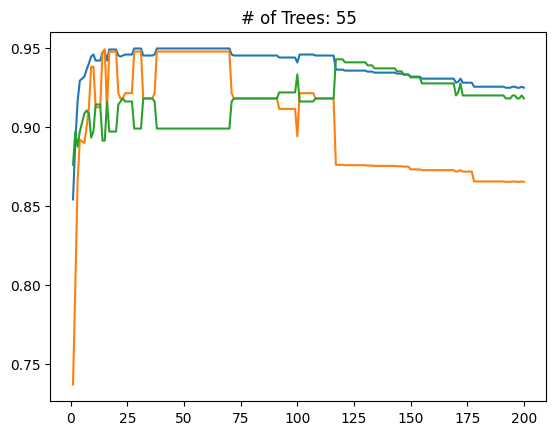

Finished iteration 1 at GAMMA: 0.005 ---- Trees = 60
Finished iteration 2 at GAMMA: 0.01 ---- Trees = 60
Finished iteration 3 at GAMMA: 0.015 ---- Trees = 60
Finished iteration 4 at GAMMA: 0.02 ---- Trees = 60
Finished iteration 5 at GAMMA: 0.025 ---- Trees = 60
Finished iteration 6 at GAMMA: 0.03 ---- Trees = 60
Finished iteration 7 at GAMMA: 0.035 ---- Trees = 60
Finished iteration 8 at GAMMA: 0.04 ---- Trees = 60
Finished iteration 9 at GAMMA: 0.045 ---- Trees = 60
Finished iteration 10 at GAMMA: 0.05 ---- Trees = 60
Finished iteration 11 at GAMMA: 0.055 ---- Trees = 60
Finished iteration 12 at GAMMA: 0.06 ---- Trees = 60
Finished iteration 13 at GAMMA: 0.065 ---- Trees = 60
Finished iteration 14 at GAMMA: 0.07 ---- Trees = 60
Finished iteration 15 at GAMMA: 0.075 ---- Trees = 60
Finished iteration 16 at GAMMA: 0.08 ---- Trees = 60
Finished iteration 17 at GAMMA: 0.085 ---- Trees = 60
Finished iteration 18 at GAMMA: 0.09 ---- Trees = 60
Finished iteration 19 at GAMMA: 0.095 ---- Tre

Finished iteration 150 at GAMMA: 0.75 ---- Trees = 60
Finished iteration 151 at GAMMA: 0.755 ---- Trees = 60
Finished iteration 152 at GAMMA: 0.76 ---- Trees = 60
Finished iteration 153 at GAMMA: 0.765 ---- Trees = 60
Finished iteration 154 at GAMMA: 0.77 ---- Trees = 60
Finished iteration 155 at GAMMA: 0.775 ---- Trees = 60
Finished iteration 156 at GAMMA: 0.78 ---- Trees = 60
Finished iteration 157 at GAMMA: 0.785 ---- Trees = 60
Finished iteration 158 at GAMMA: 0.79 ---- Trees = 60
Finished iteration 159 at GAMMA: 0.795 ---- Trees = 60
Finished iteration 160 at GAMMA: 0.8 ---- Trees = 60
Finished iteration 161 at GAMMA: 0.805 ---- Trees = 60
Finished iteration 162 at GAMMA: 0.81 ---- Trees = 60
Finished iteration 163 at GAMMA: 0.8150000000000001 ---- Trees = 60
Finished iteration 164 at GAMMA: 0.8200000000000001 ---- Trees = 60
Finished iteration 165 at GAMMA: 0.8250000000000001 ---- Trees = 60
Finished iteration 166 at GAMMA: 0.8300000000000001 ---- Trees = 60
Finished iteration 16

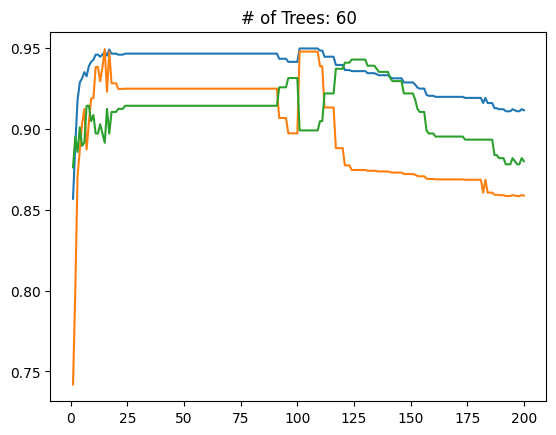

Finished iteration 1 at GAMMA: 0.005 ---- Trees = 65
Finished iteration 2 at GAMMA: 0.01 ---- Trees = 65
Finished iteration 3 at GAMMA: 0.015 ---- Trees = 65
Finished iteration 4 at GAMMA: 0.02 ---- Trees = 65
Finished iteration 5 at GAMMA: 0.025 ---- Trees = 65
Finished iteration 6 at GAMMA: 0.03 ---- Trees = 65
Finished iteration 7 at GAMMA: 0.035 ---- Trees = 65
Finished iteration 8 at GAMMA: 0.04 ---- Trees = 65
Finished iteration 9 at GAMMA: 0.045 ---- Trees = 65
Finished iteration 10 at GAMMA: 0.05 ---- Trees = 65
Finished iteration 11 at GAMMA: 0.055 ---- Trees = 65
Finished iteration 12 at GAMMA: 0.06 ---- Trees = 65
Finished iteration 13 at GAMMA: 0.065 ---- Trees = 65
Finished iteration 14 at GAMMA: 0.07 ---- Trees = 65
Finished iteration 15 at GAMMA: 0.075 ---- Trees = 65
Finished iteration 16 at GAMMA: 0.08 ---- Trees = 65
Finished iteration 17 at GAMMA: 0.085 ---- Trees = 65
Finished iteration 18 at GAMMA: 0.09 ---- Trees = 65
Finished iteration 19 at GAMMA: 0.095 ---- Tre

Finished iteration 150 at GAMMA: 0.75 ---- Trees = 65
Finished iteration 151 at GAMMA: 0.755 ---- Trees = 65
Finished iteration 152 at GAMMA: 0.76 ---- Trees = 65
Finished iteration 153 at GAMMA: 0.765 ---- Trees = 65
Finished iteration 154 at GAMMA: 0.77 ---- Trees = 65
Finished iteration 155 at GAMMA: 0.775 ---- Trees = 65
Finished iteration 156 at GAMMA: 0.78 ---- Trees = 65
Finished iteration 157 at GAMMA: 0.785 ---- Trees = 65
Finished iteration 158 at GAMMA: 0.79 ---- Trees = 65
Finished iteration 159 at GAMMA: 0.795 ---- Trees = 65
Finished iteration 160 at GAMMA: 0.8 ---- Trees = 65
Finished iteration 161 at GAMMA: 0.805 ---- Trees = 65
Finished iteration 162 at GAMMA: 0.81 ---- Trees = 65
Finished iteration 163 at GAMMA: 0.8150000000000001 ---- Trees = 65
Finished iteration 164 at GAMMA: 0.8200000000000001 ---- Trees = 65
Finished iteration 165 at GAMMA: 0.8250000000000001 ---- Trees = 65
Finished iteration 166 at GAMMA: 0.8300000000000001 ---- Trees = 65
Finished iteration 16

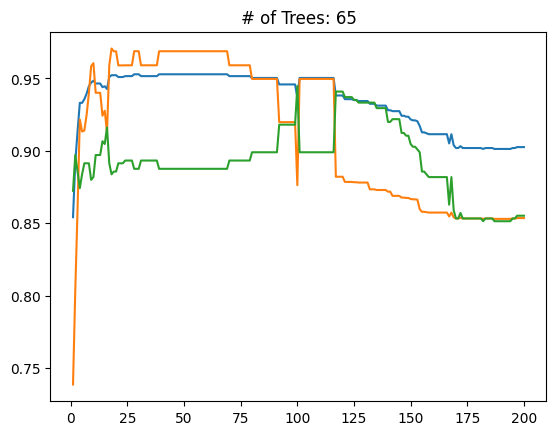

Finished iteration 1 at GAMMA: 0.005 ---- Trees = 70
Finished iteration 2 at GAMMA: 0.01 ---- Trees = 70
Finished iteration 3 at GAMMA: 0.015 ---- Trees = 70
Finished iteration 4 at GAMMA: 0.02 ---- Trees = 70
Finished iteration 5 at GAMMA: 0.025 ---- Trees = 70
Finished iteration 6 at GAMMA: 0.03 ---- Trees = 70
Finished iteration 7 at GAMMA: 0.035 ---- Trees = 70
Finished iteration 8 at GAMMA: 0.04 ---- Trees = 70
Finished iteration 9 at GAMMA: 0.045 ---- Trees = 70
Finished iteration 10 at GAMMA: 0.05 ---- Trees = 70
Finished iteration 11 at GAMMA: 0.055 ---- Trees = 70
Finished iteration 12 at GAMMA: 0.06 ---- Trees = 70
Finished iteration 13 at GAMMA: 0.065 ---- Trees = 70
Finished iteration 14 at GAMMA: 0.07 ---- Trees = 70
Finished iteration 15 at GAMMA: 0.075 ---- Trees = 70
Finished iteration 16 at GAMMA: 0.08 ---- Trees = 70
Finished iteration 17 at GAMMA: 0.085 ---- Trees = 70
Finished iteration 18 at GAMMA: 0.09 ---- Trees = 70
Finished iteration 19 at GAMMA: 0.095 ---- Tre

Finished iteration 150 at GAMMA: 0.75 ---- Trees = 70
Finished iteration 151 at GAMMA: 0.755 ---- Trees = 70
Finished iteration 152 at GAMMA: 0.76 ---- Trees = 70
Finished iteration 153 at GAMMA: 0.765 ---- Trees = 70
Finished iteration 154 at GAMMA: 0.77 ---- Trees = 70
Finished iteration 155 at GAMMA: 0.775 ---- Trees = 70
Finished iteration 156 at GAMMA: 0.78 ---- Trees = 70
Finished iteration 157 at GAMMA: 0.785 ---- Trees = 70
Finished iteration 158 at GAMMA: 0.79 ---- Trees = 70
Finished iteration 159 at GAMMA: 0.795 ---- Trees = 70
Finished iteration 160 at GAMMA: 0.8 ---- Trees = 70
Finished iteration 161 at GAMMA: 0.805 ---- Trees = 70
Finished iteration 162 at GAMMA: 0.81 ---- Trees = 70
Finished iteration 163 at GAMMA: 0.8150000000000001 ---- Trees = 70
Finished iteration 164 at GAMMA: 0.8200000000000001 ---- Trees = 70
Finished iteration 165 at GAMMA: 0.8250000000000001 ---- Trees = 70
Finished iteration 166 at GAMMA: 0.8300000000000001 ---- Trees = 70
Finished iteration 16

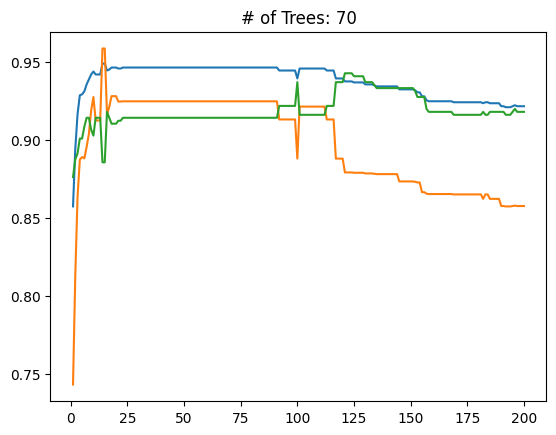

Finished iteration 1 at GAMMA: 0.005 ---- Trees = 75
Finished iteration 2 at GAMMA: 0.01 ---- Trees = 75
Finished iteration 3 at GAMMA: 0.015 ---- Trees = 75
Finished iteration 4 at GAMMA: 0.02 ---- Trees = 75
Finished iteration 5 at GAMMA: 0.025 ---- Trees = 75
Finished iteration 6 at GAMMA: 0.03 ---- Trees = 75
Finished iteration 7 at GAMMA: 0.035 ---- Trees = 75
Finished iteration 8 at GAMMA: 0.04 ---- Trees = 75
Finished iteration 9 at GAMMA: 0.045 ---- Trees = 75
Finished iteration 10 at GAMMA: 0.05 ---- Trees = 75
Finished iteration 11 at GAMMA: 0.055 ---- Trees = 75
Finished iteration 12 at GAMMA: 0.06 ---- Trees = 75
Finished iteration 13 at GAMMA: 0.065 ---- Trees = 75
Finished iteration 14 at GAMMA: 0.07 ---- Trees = 75
Finished iteration 15 at GAMMA: 0.075 ---- Trees = 75
Finished iteration 16 at GAMMA: 0.08 ---- Trees = 75
Finished iteration 17 at GAMMA: 0.085 ---- Trees = 75
Finished iteration 18 at GAMMA: 0.09 ---- Trees = 75
Finished iteration 19 at GAMMA: 0.095 ---- Tre

Finished iteration 150 at GAMMA: 0.75 ---- Trees = 75
Finished iteration 151 at GAMMA: 0.755 ---- Trees = 75
Finished iteration 152 at GAMMA: 0.76 ---- Trees = 75
Finished iteration 153 at GAMMA: 0.765 ---- Trees = 75
Finished iteration 154 at GAMMA: 0.77 ---- Trees = 75
Finished iteration 155 at GAMMA: 0.775 ---- Trees = 75
Finished iteration 156 at GAMMA: 0.78 ---- Trees = 75
Finished iteration 157 at GAMMA: 0.785 ---- Trees = 75
Finished iteration 158 at GAMMA: 0.79 ---- Trees = 75
Finished iteration 159 at GAMMA: 0.795 ---- Trees = 75
Finished iteration 160 at GAMMA: 0.8 ---- Trees = 75
Finished iteration 161 at GAMMA: 0.805 ---- Trees = 75
Finished iteration 162 at GAMMA: 0.81 ---- Trees = 75
Finished iteration 163 at GAMMA: 0.8150000000000001 ---- Trees = 75
Finished iteration 164 at GAMMA: 0.8200000000000001 ---- Trees = 75
Finished iteration 165 at GAMMA: 0.8250000000000001 ---- Trees = 75
Finished iteration 166 at GAMMA: 0.8300000000000001 ---- Trees = 75
Finished iteration 16

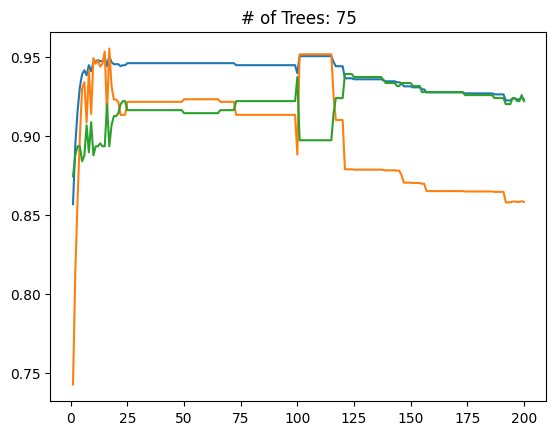

Finished iteration 1 at GAMMA: 0.005 ---- Trees = 80
Finished iteration 2 at GAMMA: 0.01 ---- Trees = 80
Finished iteration 3 at GAMMA: 0.015 ---- Trees = 80
Finished iteration 4 at GAMMA: 0.02 ---- Trees = 80
Finished iteration 5 at GAMMA: 0.025 ---- Trees = 80
Finished iteration 6 at GAMMA: 0.03 ---- Trees = 80
Finished iteration 7 at GAMMA: 0.035 ---- Trees = 80
Finished iteration 8 at GAMMA: 0.04 ---- Trees = 80
Finished iteration 9 at GAMMA: 0.045 ---- Trees = 80
Finished iteration 10 at GAMMA: 0.05 ---- Trees = 80
Finished iteration 11 at GAMMA: 0.055 ---- Trees = 80
Finished iteration 12 at GAMMA: 0.06 ---- Trees = 80
Finished iteration 13 at GAMMA: 0.065 ---- Trees = 80
Finished iteration 14 at GAMMA: 0.07 ---- Trees = 80
Finished iteration 15 at GAMMA: 0.075 ---- Trees = 80
Finished iteration 16 at GAMMA: 0.08 ---- Trees = 80
Finished iteration 17 at GAMMA: 0.085 ---- Trees = 80
Finished iteration 18 at GAMMA: 0.09 ---- Trees = 80
Finished iteration 19 at GAMMA: 0.095 ---- Tre

Finished iteration 150 at GAMMA: 0.75 ---- Trees = 80
Finished iteration 151 at GAMMA: 0.755 ---- Trees = 80
Finished iteration 152 at GAMMA: 0.76 ---- Trees = 80
Finished iteration 153 at GAMMA: 0.765 ---- Trees = 80
Finished iteration 154 at GAMMA: 0.77 ---- Trees = 80
Finished iteration 155 at GAMMA: 0.775 ---- Trees = 80
Finished iteration 156 at GAMMA: 0.78 ---- Trees = 80
Finished iteration 157 at GAMMA: 0.785 ---- Trees = 80
Finished iteration 158 at GAMMA: 0.79 ---- Trees = 80
Finished iteration 159 at GAMMA: 0.795 ---- Trees = 80
Finished iteration 160 at GAMMA: 0.8 ---- Trees = 80
Finished iteration 161 at GAMMA: 0.805 ---- Trees = 80
Finished iteration 162 at GAMMA: 0.81 ---- Trees = 80
Finished iteration 163 at GAMMA: 0.8150000000000001 ---- Trees = 80
Finished iteration 164 at GAMMA: 0.8200000000000001 ---- Trees = 80
Finished iteration 165 at GAMMA: 0.8250000000000001 ---- Trees = 80
Finished iteration 166 at GAMMA: 0.8300000000000001 ---- Trees = 80
Finished iteration 16

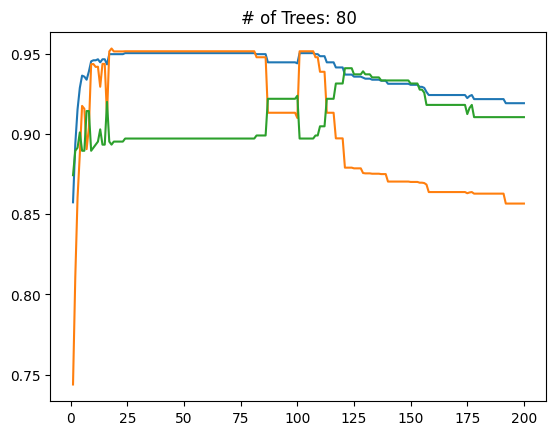

Finished iteration 1 at GAMMA: 0.005 ---- Trees = 85
Finished iteration 2 at GAMMA: 0.01 ---- Trees = 85
Finished iteration 3 at GAMMA: 0.015 ---- Trees = 85
Finished iteration 4 at GAMMA: 0.02 ---- Trees = 85
Finished iteration 5 at GAMMA: 0.025 ---- Trees = 85
Finished iteration 6 at GAMMA: 0.03 ---- Trees = 85
Finished iteration 7 at GAMMA: 0.035 ---- Trees = 85
Finished iteration 8 at GAMMA: 0.04 ---- Trees = 85
Finished iteration 9 at GAMMA: 0.045 ---- Trees = 85
Finished iteration 10 at GAMMA: 0.05 ---- Trees = 85
Finished iteration 11 at GAMMA: 0.055 ---- Trees = 85
Finished iteration 12 at GAMMA: 0.06 ---- Trees = 85
Finished iteration 13 at GAMMA: 0.065 ---- Trees = 85
Finished iteration 14 at GAMMA: 0.07 ---- Trees = 85
Finished iteration 15 at GAMMA: 0.075 ---- Trees = 85
Finished iteration 16 at GAMMA: 0.08 ---- Trees = 85
Finished iteration 17 at GAMMA: 0.085 ---- Trees = 85
Finished iteration 18 at GAMMA: 0.09 ---- Trees = 85
Finished iteration 19 at GAMMA: 0.095 ---- Tre

Finished iteration 150 at GAMMA: 0.75 ---- Trees = 85
Finished iteration 151 at GAMMA: 0.755 ---- Trees = 85
Finished iteration 152 at GAMMA: 0.76 ---- Trees = 85
Finished iteration 153 at GAMMA: 0.765 ---- Trees = 85
Finished iteration 154 at GAMMA: 0.77 ---- Trees = 85
Finished iteration 155 at GAMMA: 0.775 ---- Trees = 85
Finished iteration 156 at GAMMA: 0.78 ---- Trees = 85
Finished iteration 157 at GAMMA: 0.785 ---- Trees = 85
Finished iteration 158 at GAMMA: 0.79 ---- Trees = 85
Finished iteration 159 at GAMMA: 0.795 ---- Trees = 85
Finished iteration 160 at GAMMA: 0.8 ---- Trees = 85
Finished iteration 161 at GAMMA: 0.805 ---- Trees = 85
Finished iteration 162 at GAMMA: 0.81 ---- Trees = 85
Finished iteration 163 at GAMMA: 0.8150000000000001 ---- Trees = 85
Finished iteration 164 at GAMMA: 0.8200000000000001 ---- Trees = 85
Finished iteration 165 at GAMMA: 0.8250000000000001 ---- Trees = 85
Finished iteration 166 at GAMMA: 0.8300000000000001 ---- Trees = 85
Finished iteration 16

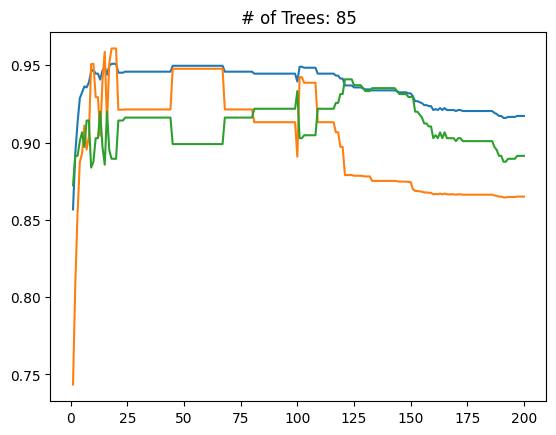

Finished iteration 1 at GAMMA: 0.005 ---- Trees = 90
Finished iteration 2 at GAMMA: 0.01 ---- Trees = 90
Finished iteration 3 at GAMMA: 0.015 ---- Trees = 90
Finished iteration 4 at GAMMA: 0.02 ---- Trees = 90
Finished iteration 5 at GAMMA: 0.025 ---- Trees = 90
Finished iteration 6 at GAMMA: 0.03 ---- Trees = 90
Finished iteration 7 at GAMMA: 0.035 ---- Trees = 90
Finished iteration 8 at GAMMA: 0.04 ---- Trees = 90
Finished iteration 9 at GAMMA: 0.045 ---- Trees = 90
Finished iteration 10 at GAMMA: 0.05 ---- Trees = 90
Finished iteration 11 at GAMMA: 0.055 ---- Trees = 90
Finished iteration 12 at GAMMA: 0.06 ---- Trees = 90
Finished iteration 13 at GAMMA: 0.065 ---- Trees = 90
Finished iteration 14 at GAMMA: 0.07 ---- Trees = 90
Finished iteration 15 at GAMMA: 0.075 ---- Trees = 90
Finished iteration 16 at GAMMA: 0.08 ---- Trees = 90
Finished iteration 17 at GAMMA: 0.085 ---- Trees = 90
Finished iteration 18 at GAMMA: 0.09 ---- Trees = 90
Finished iteration 19 at GAMMA: 0.095 ---- Tre

Finished iteration 150 at GAMMA: 0.75 ---- Trees = 90
Finished iteration 151 at GAMMA: 0.755 ---- Trees = 90
Finished iteration 152 at GAMMA: 0.76 ---- Trees = 90
Finished iteration 153 at GAMMA: 0.765 ---- Trees = 90
Finished iteration 154 at GAMMA: 0.77 ---- Trees = 90
Finished iteration 155 at GAMMA: 0.775 ---- Trees = 90
Finished iteration 156 at GAMMA: 0.78 ---- Trees = 90
Finished iteration 157 at GAMMA: 0.785 ---- Trees = 90
Finished iteration 158 at GAMMA: 0.79 ---- Trees = 90
Finished iteration 159 at GAMMA: 0.795 ---- Trees = 90
Finished iteration 160 at GAMMA: 0.8 ---- Trees = 90
Finished iteration 161 at GAMMA: 0.805 ---- Trees = 90
Finished iteration 162 at GAMMA: 0.81 ---- Trees = 90
Finished iteration 163 at GAMMA: 0.8150000000000001 ---- Trees = 90
Finished iteration 164 at GAMMA: 0.8200000000000001 ---- Trees = 90
Finished iteration 165 at GAMMA: 0.8250000000000001 ---- Trees = 90
Finished iteration 166 at GAMMA: 0.8300000000000001 ---- Trees = 90
Finished iteration 16

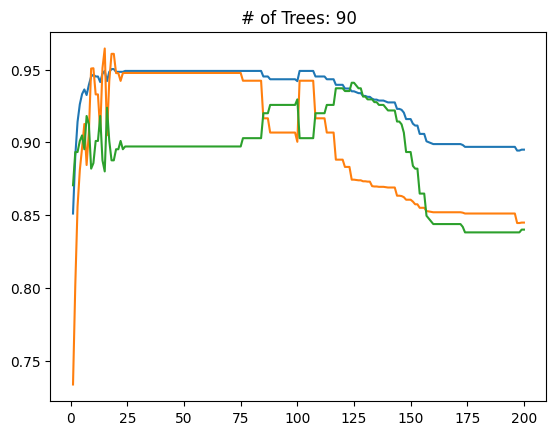

Finished iteration 1 at GAMMA: 0.005 ---- Trees = 95
Finished iteration 2 at GAMMA: 0.01 ---- Trees = 95
Finished iteration 3 at GAMMA: 0.015 ---- Trees = 95
Finished iteration 4 at GAMMA: 0.02 ---- Trees = 95
Finished iteration 5 at GAMMA: 0.025 ---- Trees = 95
Finished iteration 6 at GAMMA: 0.03 ---- Trees = 95
Finished iteration 7 at GAMMA: 0.035 ---- Trees = 95
Finished iteration 8 at GAMMA: 0.04 ---- Trees = 95
Finished iteration 9 at GAMMA: 0.045 ---- Trees = 95
Finished iteration 10 at GAMMA: 0.05 ---- Trees = 95
Finished iteration 11 at GAMMA: 0.055 ---- Trees = 95
Finished iteration 12 at GAMMA: 0.06 ---- Trees = 95
Finished iteration 13 at GAMMA: 0.065 ---- Trees = 95
Finished iteration 14 at GAMMA: 0.07 ---- Trees = 95
Finished iteration 15 at GAMMA: 0.075 ---- Trees = 95
Finished iteration 16 at GAMMA: 0.08 ---- Trees = 95
Finished iteration 17 at GAMMA: 0.085 ---- Trees = 95
Finished iteration 18 at GAMMA: 0.09 ---- Trees = 95
Finished iteration 19 at GAMMA: 0.095 ---- Tre

Finished iteration 150 at GAMMA: 0.75 ---- Trees = 95
Finished iteration 151 at GAMMA: 0.755 ---- Trees = 95
Finished iteration 152 at GAMMA: 0.76 ---- Trees = 95
Finished iteration 153 at GAMMA: 0.765 ---- Trees = 95
Finished iteration 154 at GAMMA: 0.77 ---- Trees = 95
Finished iteration 155 at GAMMA: 0.775 ---- Trees = 95
Finished iteration 156 at GAMMA: 0.78 ---- Trees = 95
Finished iteration 157 at GAMMA: 0.785 ---- Trees = 95
Finished iteration 158 at GAMMA: 0.79 ---- Trees = 95
Finished iteration 159 at GAMMA: 0.795 ---- Trees = 95
Finished iteration 160 at GAMMA: 0.8 ---- Trees = 95
Finished iteration 161 at GAMMA: 0.805 ---- Trees = 95
Finished iteration 162 at GAMMA: 0.81 ---- Trees = 95
Finished iteration 163 at GAMMA: 0.8150000000000001 ---- Trees = 95
Finished iteration 164 at GAMMA: 0.8200000000000001 ---- Trees = 95
Finished iteration 165 at GAMMA: 0.8250000000000001 ---- Trees = 95
Finished iteration 166 at GAMMA: 0.8300000000000001 ---- Trees = 95
Finished iteration 16

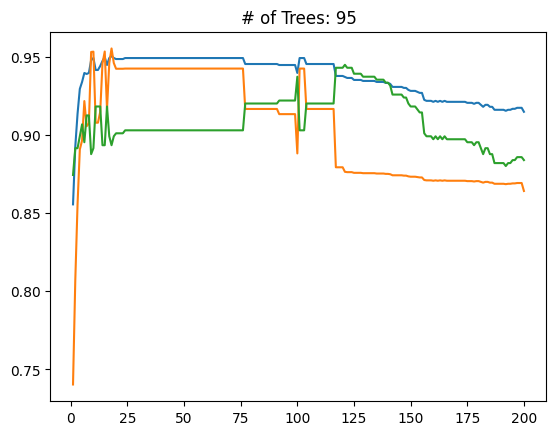

Finished iteration 1 at GAMMA: 0.005 ---- Trees = 100
Finished iteration 2 at GAMMA: 0.01 ---- Trees = 100
Finished iteration 3 at GAMMA: 0.015 ---- Trees = 100
Finished iteration 4 at GAMMA: 0.02 ---- Trees = 100
Finished iteration 5 at GAMMA: 0.025 ---- Trees = 100
Finished iteration 6 at GAMMA: 0.03 ---- Trees = 100
Finished iteration 7 at GAMMA: 0.035 ---- Trees = 100
Finished iteration 8 at GAMMA: 0.04 ---- Trees = 100
Finished iteration 9 at GAMMA: 0.045 ---- Trees = 100
Finished iteration 10 at GAMMA: 0.05 ---- Trees = 100
Finished iteration 11 at GAMMA: 0.055 ---- Trees = 100
Finished iteration 12 at GAMMA: 0.06 ---- Trees = 100
Finished iteration 13 at GAMMA: 0.065 ---- Trees = 100
Finished iteration 14 at GAMMA: 0.07 ---- Trees = 100
Finished iteration 15 at GAMMA: 0.075 ---- Trees = 100
Finished iteration 16 at GAMMA: 0.08 ---- Trees = 100
Finished iteration 17 at GAMMA: 0.085 ---- Trees = 100
Finished iteration 18 at GAMMA: 0.09 ---- Trees = 100
Finished iteration 19 at GAM

Finished iteration 147 at GAMMA: 0.735 ---- Trees = 100
Finished iteration 148 at GAMMA: 0.74 ---- Trees = 100
Finished iteration 149 at GAMMA: 0.745 ---- Trees = 100
Finished iteration 150 at GAMMA: 0.75 ---- Trees = 100
Finished iteration 151 at GAMMA: 0.755 ---- Trees = 100
Finished iteration 152 at GAMMA: 0.76 ---- Trees = 100
Finished iteration 153 at GAMMA: 0.765 ---- Trees = 100
Finished iteration 154 at GAMMA: 0.77 ---- Trees = 100
Finished iteration 155 at GAMMA: 0.775 ---- Trees = 100
Finished iteration 156 at GAMMA: 0.78 ---- Trees = 100
Finished iteration 157 at GAMMA: 0.785 ---- Trees = 100
Finished iteration 158 at GAMMA: 0.79 ---- Trees = 100
Finished iteration 159 at GAMMA: 0.795 ---- Trees = 100
Finished iteration 160 at GAMMA: 0.8 ---- Trees = 100
Finished iteration 161 at GAMMA: 0.805 ---- Trees = 100
Finished iteration 162 at GAMMA: 0.81 ---- Trees = 100
Finished iteration 163 at GAMMA: 0.8150000000000001 ---- Trees = 100
Finished iteration 164 at GAMMA: 0.820000000

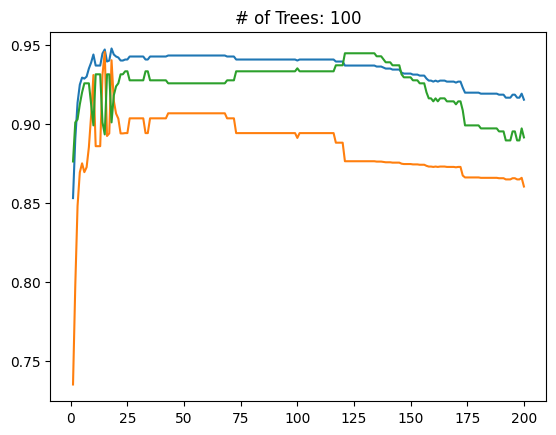

Finished iteration 1 at GAMMA: 0.005 ---- Trees = 105
Finished iteration 2 at GAMMA: 0.01 ---- Trees = 105
Finished iteration 3 at GAMMA: 0.015 ---- Trees = 105
Finished iteration 4 at GAMMA: 0.02 ---- Trees = 105
Finished iteration 5 at GAMMA: 0.025 ---- Trees = 105
Finished iteration 6 at GAMMA: 0.03 ---- Trees = 105
Finished iteration 7 at GAMMA: 0.035 ---- Trees = 105
Finished iteration 8 at GAMMA: 0.04 ---- Trees = 105
Finished iteration 9 at GAMMA: 0.045 ---- Trees = 105
Finished iteration 10 at GAMMA: 0.05 ---- Trees = 105
Finished iteration 11 at GAMMA: 0.055 ---- Trees = 105
Finished iteration 12 at GAMMA: 0.06 ---- Trees = 105
Finished iteration 13 at GAMMA: 0.065 ---- Trees = 105
Finished iteration 14 at GAMMA: 0.07 ---- Trees = 105
Finished iteration 15 at GAMMA: 0.075 ---- Trees = 105
Finished iteration 16 at GAMMA: 0.08 ---- Trees = 105
Finished iteration 17 at GAMMA: 0.085 ---- Trees = 105
Finished iteration 18 at GAMMA: 0.09 ---- Trees = 105
Finished iteration 19 at GAM

Finished iteration 147 at GAMMA: 0.735 ---- Trees = 105
Finished iteration 148 at GAMMA: 0.74 ---- Trees = 105
Finished iteration 149 at GAMMA: 0.745 ---- Trees = 105
Finished iteration 150 at GAMMA: 0.75 ---- Trees = 105
Finished iteration 151 at GAMMA: 0.755 ---- Trees = 105
Finished iteration 152 at GAMMA: 0.76 ---- Trees = 105
Finished iteration 153 at GAMMA: 0.765 ---- Trees = 105
Finished iteration 154 at GAMMA: 0.77 ---- Trees = 105
Finished iteration 155 at GAMMA: 0.775 ---- Trees = 105
Finished iteration 156 at GAMMA: 0.78 ---- Trees = 105
Finished iteration 157 at GAMMA: 0.785 ---- Trees = 105
Finished iteration 158 at GAMMA: 0.79 ---- Trees = 105
Finished iteration 159 at GAMMA: 0.795 ---- Trees = 105
Finished iteration 160 at GAMMA: 0.8 ---- Trees = 105
Finished iteration 161 at GAMMA: 0.805 ---- Trees = 105
Finished iteration 162 at GAMMA: 0.81 ---- Trees = 105
Finished iteration 163 at GAMMA: 0.8150000000000001 ---- Trees = 105
Finished iteration 164 at GAMMA: 0.820000000

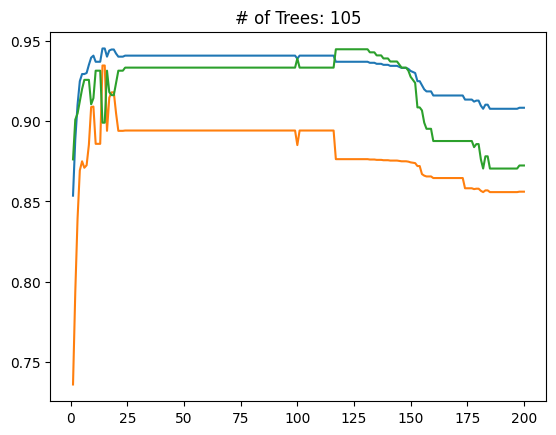

Finished iteration 1 at GAMMA: 0.005 ---- Trees = 110
Finished iteration 2 at GAMMA: 0.01 ---- Trees = 110
Finished iteration 3 at GAMMA: 0.015 ---- Trees = 110
Finished iteration 4 at GAMMA: 0.02 ---- Trees = 110
Finished iteration 5 at GAMMA: 0.025 ---- Trees = 110
Finished iteration 6 at GAMMA: 0.03 ---- Trees = 110
Finished iteration 7 at GAMMA: 0.035 ---- Trees = 110
Finished iteration 8 at GAMMA: 0.04 ---- Trees = 110
Finished iteration 9 at GAMMA: 0.045 ---- Trees = 110
Finished iteration 10 at GAMMA: 0.05 ---- Trees = 110
Finished iteration 11 at GAMMA: 0.055 ---- Trees = 110
Finished iteration 12 at GAMMA: 0.06 ---- Trees = 110
Finished iteration 13 at GAMMA: 0.065 ---- Trees = 110
Finished iteration 14 at GAMMA: 0.07 ---- Trees = 110
Finished iteration 15 at GAMMA: 0.075 ---- Trees = 110
Finished iteration 16 at GAMMA: 0.08 ---- Trees = 110
Finished iteration 17 at GAMMA: 0.085 ---- Trees = 110
Finished iteration 18 at GAMMA: 0.09 ---- Trees = 110
Finished iteration 19 at GAM

Finished iteration 147 at GAMMA: 0.735 ---- Trees = 110
Finished iteration 148 at GAMMA: 0.74 ---- Trees = 110
Finished iteration 149 at GAMMA: 0.745 ---- Trees = 110
Finished iteration 150 at GAMMA: 0.75 ---- Trees = 110
Finished iteration 151 at GAMMA: 0.755 ---- Trees = 110
Finished iteration 152 at GAMMA: 0.76 ---- Trees = 110
Finished iteration 153 at GAMMA: 0.765 ---- Trees = 110
Finished iteration 154 at GAMMA: 0.77 ---- Trees = 110
Finished iteration 155 at GAMMA: 0.775 ---- Trees = 110
Finished iteration 156 at GAMMA: 0.78 ---- Trees = 110
Finished iteration 157 at GAMMA: 0.785 ---- Trees = 110
Finished iteration 158 at GAMMA: 0.79 ---- Trees = 110
Finished iteration 159 at GAMMA: 0.795 ---- Trees = 110
Finished iteration 160 at GAMMA: 0.8 ---- Trees = 110
Finished iteration 161 at GAMMA: 0.805 ---- Trees = 110
Finished iteration 162 at GAMMA: 0.81 ---- Trees = 110
Finished iteration 163 at GAMMA: 0.8150000000000001 ---- Trees = 110
Finished iteration 164 at GAMMA: 0.820000000

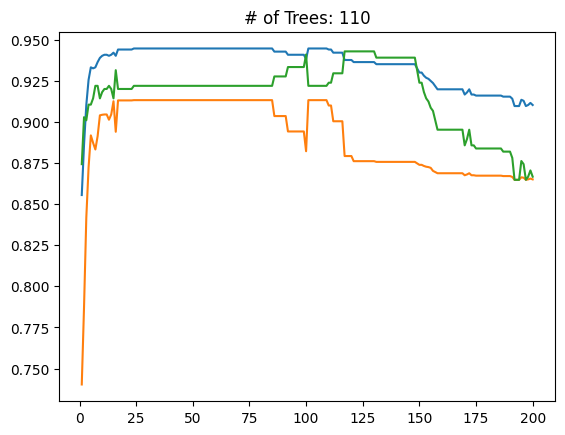

Finished iteration 1 at GAMMA: 0.005 ---- Trees = 115
Finished iteration 2 at GAMMA: 0.01 ---- Trees = 115
Finished iteration 3 at GAMMA: 0.015 ---- Trees = 115
Finished iteration 4 at GAMMA: 0.02 ---- Trees = 115
Finished iteration 5 at GAMMA: 0.025 ---- Trees = 115
Finished iteration 6 at GAMMA: 0.03 ---- Trees = 115
Finished iteration 7 at GAMMA: 0.035 ---- Trees = 115
Finished iteration 8 at GAMMA: 0.04 ---- Trees = 115
Finished iteration 9 at GAMMA: 0.045 ---- Trees = 115
Finished iteration 10 at GAMMA: 0.05 ---- Trees = 115
Finished iteration 11 at GAMMA: 0.055 ---- Trees = 115
Finished iteration 12 at GAMMA: 0.06 ---- Trees = 115
Finished iteration 13 at GAMMA: 0.065 ---- Trees = 115
Finished iteration 14 at GAMMA: 0.07 ---- Trees = 115
Finished iteration 15 at GAMMA: 0.075 ---- Trees = 115
Finished iteration 16 at GAMMA: 0.08 ---- Trees = 115
Finished iteration 17 at GAMMA: 0.085 ---- Trees = 115
Finished iteration 18 at GAMMA: 0.09 ---- Trees = 115
Finished iteration 19 at GAM

Finished iteration 147 at GAMMA: 0.735 ---- Trees = 115
Finished iteration 148 at GAMMA: 0.74 ---- Trees = 115
Finished iteration 149 at GAMMA: 0.745 ---- Trees = 115
Finished iteration 150 at GAMMA: 0.75 ---- Trees = 115
Finished iteration 151 at GAMMA: 0.755 ---- Trees = 115
Finished iteration 152 at GAMMA: 0.76 ---- Trees = 115
Finished iteration 153 at GAMMA: 0.765 ---- Trees = 115
Finished iteration 154 at GAMMA: 0.77 ---- Trees = 115
Finished iteration 155 at GAMMA: 0.775 ---- Trees = 115
Finished iteration 156 at GAMMA: 0.78 ---- Trees = 115
Finished iteration 157 at GAMMA: 0.785 ---- Trees = 115
Finished iteration 158 at GAMMA: 0.79 ---- Trees = 115
Finished iteration 159 at GAMMA: 0.795 ---- Trees = 115
Finished iteration 160 at GAMMA: 0.8 ---- Trees = 115
Finished iteration 161 at GAMMA: 0.805 ---- Trees = 115
Finished iteration 162 at GAMMA: 0.81 ---- Trees = 115
Finished iteration 163 at GAMMA: 0.8150000000000001 ---- Trees = 115
Finished iteration 164 at GAMMA: 0.820000000

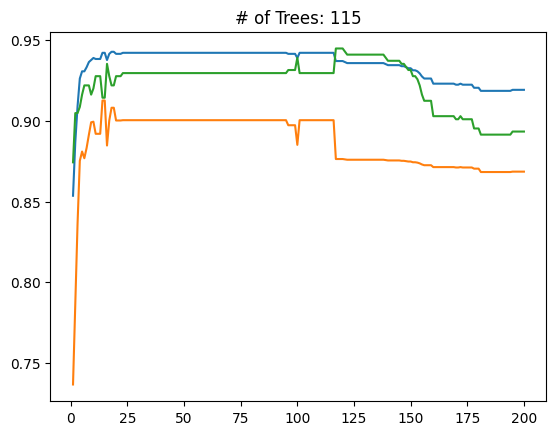

Finished iteration 1 at GAMMA: 0.005 ---- Trees = 120
Finished iteration 2 at GAMMA: 0.01 ---- Trees = 120
Finished iteration 3 at GAMMA: 0.015 ---- Trees = 120
Finished iteration 4 at GAMMA: 0.02 ---- Trees = 120
Finished iteration 5 at GAMMA: 0.025 ---- Trees = 120
Finished iteration 6 at GAMMA: 0.03 ---- Trees = 120
Finished iteration 7 at GAMMA: 0.035 ---- Trees = 120
Finished iteration 8 at GAMMA: 0.04 ---- Trees = 120
Finished iteration 9 at GAMMA: 0.045 ---- Trees = 120
Finished iteration 10 at GAMMA: 0.05 ---- Trees = 120
Finished iteration 11 at GAMMA: 0.055 ---- Trees = 120
Finished iteration 12 at GAMMA: 0.06 ---- Trees = 120
Finished iteration 13 at GAMMA: 0.065 ---- Trees = 120
Finished iteration 14 at GAMMA: 0.07 ---- Trees = 120
Finished iteration 15 at GAMMA: 0.075 ---- Trees = 120
Finished iteration 16 at GAMMA: 0.08 ---- Trees = 120
Finished iteration 17 at GAMMA: 0.085 ---- Trees = 120
Finished iteration 18 at GAMMA: 0.09 ---- Trees = 120
Finished iteration 19 at GAM

Finished iteration 147 at GAMMA: 0.735 ---- Trees = 120
Finished iteration 148 at GAMMA: 0.74 ---- Trees = 120
Finished iteration 149 at GAMMA: 0.745 ---- Trees = 120
Finished iteration 150 at GAMMA: 0.75 ---- Trees = 120
Finished iteration 151 at GAMMA: 0.755 ---- Trees = 120
Finished iteration 152 at GAMMA: 0.76 ---- Trees = 120
Finished iteration 153 at GAMMA: 0.765 ---- Trees = 120
Finished iteration 154 at GAMMA: 0.77 ---- Trees = 120
Finished iteration 155 at GAMMA: 0.775 ---- Trees = 120
Finished iteration 156 at GAMMA: 0.78 ---- Trees = 120
Finished iteration 157 at GAMMA: 0.785 ---- Trees = 120
Finished iteration 158 at GAMMA: 0.79 ---- Trees = 120
Finished iteration 159 at GAMMA: 0.795 ---- Trees = 120
Finished iteration 160 at GAMMA: 0.8 ---- Trees = 120
Finished iteration 161 at GAMMA: 0.805 ---- Trees = 120
Finished iteration 162 at GAMMA: 0.81 ---- Trees = 120
Finished iteration 163 at GAMMA: 0.8150000000000001 ---- Trees = 120
Finished iteration 164 at GAMMA: 0.820000000

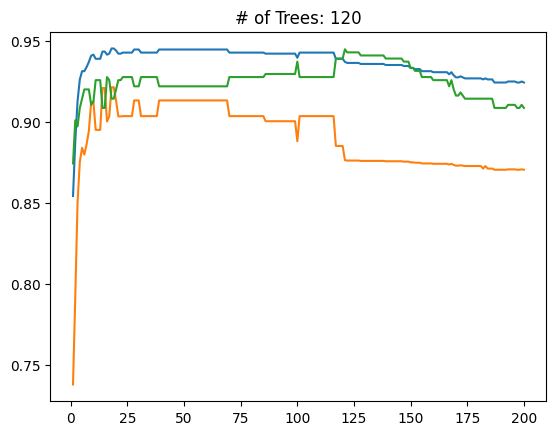

Finished iteration 1 at GAMMA: 0.005 ---- Trees = 125
Finished iteration 2 at GAMMA: 0.01 ---- Trees = 125
Finished iteration 3 at GAMMA: 0.015 ---- Trees = 125
Finished iteration 4 at GAMMA: 0.02 ---- Trees = 125
Finished iteration 5 at GAMMA: 0.025 ---- Trees = 125
Finished iteration 6 at GAMMA: 0.03 ---- Trees = 125
Finished iteration 7 at GAMMA: 0.035 ---- Trees = 125
Finished iteration 8 at GAMMA: 0.04 ---- Trees = 125
Finished iteration 9 at GAMMA: 0.045 ---- Trees = 125
Finished iteration 10 at GAMMA: 0.05 ---- Trees = 125
Finished iteration 11 at GAMMA: 0.055 ---- Trees = 125
Finished iteration 12 at GAMMA: 0.06 ---- Trees = 125
Finished iteration 13 at GAMMA: 0.065 ---- Trees = 125
Finished iteration 14 at GAMMA: 0.07 ---- Trees = 125
Finished iteration 15 at GAMMA: 0.075 ---- Trees = 125
Finished iteration 16 at GAMMA: 0.08 ---- Trees = 125
Finished iteration 17 at GAMMA: 0.085 ---- Trees = 125
Finished iteration 18 at GAMMA: 0.09 ---- Trees = 125
Finished iteration 19 at GAM

Finished iteration 147 at GAMMA: 0.735 ---- Trees = 125
Finished iteration 148 at GAMMA: 0.74 ---- Trees = 125
Finished iteration 149 at GAMMA: 0.745 ---- Trees = 125
Finished iteration 150 at GAMMA: 0.75 ---- Trees = 125
Finished iteration 151 at GAMMA: 0.755 ---- Trees = 125
Finished iteration 152 at GAMMA: 0.76 ---- Trees = 125
Finished iteration 153 at GAMMA: 0.765 ---- Trees = 125
Finished iteration 154 at GAMMA: 0.77 ---- Trees = 125
Finished iteration 155 at GAMMA: 0.775 ---- Trees = 125
Finished iteration 156 at GAMMA: 0.78 ---- Trees = 125
Finished iteration 157 at GAMMA: 0.785 ---- Trees = 125
Finished iteration 158 at GAMMA: 0.79 ---- Trees = 125
Finished iteration 159 at GAMMA: 0.795 ---- Trees = 125
Finished iteration 160 at GAMMA: 0.8 ---- Trees = 125
Finished iteration 161 at GAMMA: 0.805 ---- Trees = 125
Finished iteration 162 at GAMMA: 0.81 ---- Trees = 125
Finished iteration 163 at GAMMA: 0.8150000000000001 ---- Trees = 125
Finished iteration 164 at GAMMA: 0.820000000

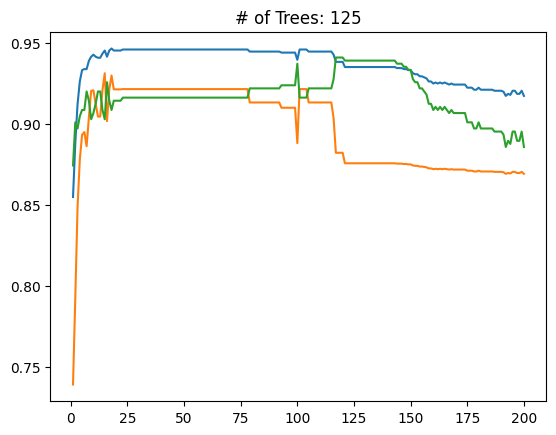

Finished iteration 1 at GAMMA: 0.005 ---- Trees = 130
Finished iteration 2 at GAMMA: 0.01 ---- Trees = 130
Finished iteration 3 at GAMMA: 0.015 ---- Trees = 130
Finished iteration 4 at GAMMA: 0.02 ---- Trees = 130
Finished iteration 5 at GAMMA: 0.025 ---- Trees = 130
Finished iteration 6 at GAMMA: 0.03 ---- Trees = 130
Finished iteration 7 at GAMMA: 0.035 ---- Trees = 130
Finished iteration 8 at GAMMA: 0.04 ---- Trees = 130
Finished iteration 9 at GAMMA: 0.045 ---- Trees = 130
Finished iteration 10 at GAMMA: 0.05 ---- Trees = 130
Finished iteration 11 at GAMMA: 0.055 ---- Trees = 130
Finished iteration 12 at GAMMA: 0.06 ---- Trees = 130
Finished iteration 13 at GAMMA: 0.065 ---- Trees = 130
Finished iteration 14 at GAMMA: 0.07 ---- Trees = 130
Finished iteration 15 at GAMMA: 0.075 ---- Trees = 130
Finished iteration 16 at GAMMA: 0.08 ---- Trees = 130
Finished iteration 17 at GAMMA: 0.085 ---- Trees = 130
Finished iteration 18 at GAMMA: 0.09 ---- Trees = 130
Finished iteration 19 at GAM

Finished iteration 147 at GAMMA: 0.735 ---- Trees = 130
Finished iteration 148 at GAMMA: 0.74 ---- Trees = 130
Finished iteration 149 at GAMMA: 0.745 ---- Trees = 130
Finished iteration 150 at GAMMA: 0.75 ---- Trees = 130
Finished iteration 151 at GAMMA: 0.755 ---- Trees = 130
Finished iteration 152 at GAMMA: 0.76 ---- Trees = 130
Finished iteration 153 at GAMMA: 0.765 ---- Trees = 130
Finished iteration 154 at GAMMA: 0.77 ---- Trees = 130
Finished iteration 155 at GAMMA: 0.775 ---- Trees = 130
Finished iteration 156 at GAMMA: 0.78 ---- Trees = 130
Finished iteration 157 at GAMMA: 0.785 ---- Trees = 130
Finished iteration 158 at GAMMA: 0.79 ---- Trees = 130
Finished iteration 159 at GAMMA: 0.795 ---- Trees = 130
Finished iteration 160 at GAMMA: 0.8 ---- Trees = 130
Finished iteration 161 at GAMMA: 0.805 ---- Trees = 130
Finished iteration 162 at GAMMA: 0.81 ---- Trees = 130
Finished iteration 163 at GAMMA: 0.8150000000000001 ---- Trees = 130
Finished iteration 164 at GAMMA: 0.820000000

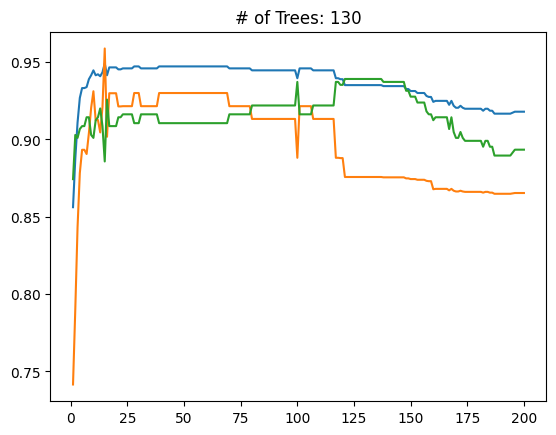

Finished iteration 1 at GAMMA: 0.005 ---- Trees = 135
Finished iteration 2 at GAMMA: 0.01 ---- Trees = 135
Finished iteration 3 at GAMMA: 0.015 ---- Trees = 135
Finished iteration 4 at GAMMA: 0.02 ---- Trees = 135
Finished iteration 5 at GAMMA: 0.025 ---- Trees = 135
Finished iteration 6 at GAMMA: 0.03 ---- Trees = 135
Finished iteration 7 at GAMMA: 0.035 ---- Trees = 135
Finished iteration 8 at GAMMA: 0.04 ---- Trees = 135
Finished iteration 9 at GAMMA: 0.045 ---- Trees = 135
Finished iteration 10 at GAMMA: 0.05 ---- Trees = 135
Finished iteration 11 at GAMMA: 0.055 ---- Trees = 135
Finished iteration 12 at GAMMA: 0.06 ---- Trees = 135
Finished iteration 13 at GAMMA: 0.065 ---- Trees = 135
Finished iteration 14 at GAMMA: 0.07 ---- Trees = 135
Finished iteration 15 at GAMMA: 0.075 ---- Trees = 135
Finished iteration 16 at GAMMA: 0.08 ---- Trees = 135
Finished iteration 17 at GAMMA: 0.085 ---- Trees = 135
Finished iteration 18 at GAMMA: 0.09 ---- Trees = 135
Finished iteration 19 at GAM

Finished iteration 147 at GAMMA: 0.735 ---- Trees = 135
Finished iteration 148 at GAMMA: 0.74 ---- Trees = 135
Finished iteration 149 at GAMMA: 0.745 ---- Trees = 135
Finished iteration 150 at GAMMA: 0.75 ---- Trees = 135
Finished iteration 151 at GAMMA: 0.755 ---- Trees = 135
Finished iteration 152 at GAMMA: 0.76 ---- Trees = 135
Finished iteration 153 at GAMMA: 0.765 ---- Trees = 135
Finished iteration 154 at GAMMA: 0.77 ---- Trees = 135
Finished iteration 155 at GAMMA: 0.775 ---- Trees = 135
Finished iteration 156 at GAMMA: 0.78 ---- Trees = 135
Finished iteration 157 at GAMMA: 0.785 ---- Trees = 135
Finished iteration 158 at GAMMA: 0.79 ---- Trees = 135
Finished iteration 159 at GAMMA: 0.795 ---- Trees = 135
Finished iteration 160 at GAMMA: 0.8 ---- Trees = 135
Finished iteration 161 at GAMMA: 0.805 ---- Trees = 135
Finished iteration 162 at GAMMA: 0.81 ---- Trees = 135
Finished iteration 163 at GAMMA: 0.8150000000000001 ---- Trees = 135
Finished iteration 164 at GAMMA: 0.820000000

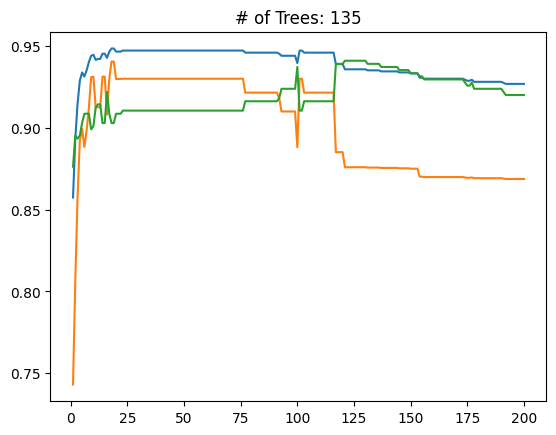

Finished iteration 1 at GAMMA: 0.005 ---- Trees = 140
Finished iteration 2 at GAMMA: 0.01 ---- Trees = 140
Finished iteration 3 at GAMMA: 0.015 ---- Trees = 140
Finished iteration 4 at GAMMA: 0.02 ---- Trees = 140
Finished iteration 5 at GAMMA: 0.025 ---- Trees = 140
Finished iteration 6 at GAMMA: 0.03 ---- Trees = 140
Finished iteration 7 at GAMMA: 0.035 ---- Trees = 140
Finished iteration 8 at GAMMA: 0.04 ---- Trees = 140
Finished iteration 9 at GAMMA: 0.045 ---- Trees = 140
Finished iteration 10 at GAMMA: 0.05 ---- Trees = 140
Finished iteration 11 at GAMMA: 0.055 ---- Trees = 140
Finished iteration 12 at GAMMA: 0.06 ---- Trees = 140
Finished iteration 13 at GAMMA: 0.065 ---- Trees = 140
Finished iteration 14 at GAMMA: 0.07 ---- Trees = 140
Finished iteration 15 at GAMMA: 0.075 ---- Trees = 140
Finished iteration 16 at GAMMA: 0.08 ---- Trees = 140
Finished iteration 17 at GAMMA: 0.085 ---- Trees = 140
Finished iteration 18 at GAMMA: 0.09 ---- Trees = 140
Finished iteration 19 at GAM

Finished iteration 147 at GAMMA: 0.735 ---- Trees = 140
Finished iteration 148 at GAMMA: 0.74 ---- Trees = 140
Finished iteration 149 at GAMMA: 0.745 ---- Trees = 140
Finished iteration 150 at GAMMA: 0.75 ---- Trees = 140
Finished iteration 151 at GAMMA: 0.755 ---- Trees = 140
Finished iteration 152 at GAMMA: 0.76 ---- Trees = 140
Finished iteration 153 at GAMMA: 0.765 ---- Trees = 140
Finished iteration 154 at GAMMA: 0.77 ---- Trees = 140
Finished iteration 155 at GAMMA: 0.775 ---- Trees = 140
Finished iteration 156 at GAMMA: 0.78 ---- Trees = 140
Finished iteration 157 at GAMMA: 0.785 ---- Trees = 140
Finished iteration 158 at GAMMA: 0.79 ---- Trees = 140
Finished iteration 159 at GAMMA: 0.795 ---- Trees = 140
Finished iteration 160 at GAMMA: 0.8 ---- Trees = 140
Finished iteration 161 at GAMMA: 0.805 ---- Trees = 140
Finished iteration 162 at GAMMA: 0.81 ---- Trees = 140
Finished iteration 163 at GAMMA: 0.8150000000000001 ---- Trees = 140
Finished iteration 164 at GAMMA: 0.820000000

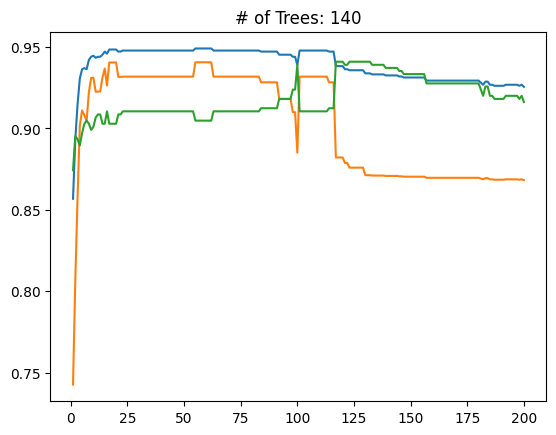

Finished iteration 1 at GAMMA: 0.005 ---- Trees = 145
Finished iteration 2 at GAMMA: 0.01 ---- Trees = 145
Finished iteration 3 at GAMMA: 0.015 ---- Trees = 145
Finished iteration 4 at GAMMA: 0.02 ---- Trees = 145
Finished iteration 5 at GAMMA: 0.025 ---- Trees = 145
Finished iteration 6 at GAMMA: 0.03 ---- Trees = 145
Finished iteration 7 at GAMMA: 0.035 ---- Trees = 145
Finished iteration 8 at GAMMA: 0.04 ---- Trees = 145
Finished iteration 9 at GAMMA: 0.045 ---- Trees = 145
Finished iteration 10 at GAMMA: 0.05 ---- Trees = 145
Finished iteration 11 at GAMMA: 0.055 ---- Trees = 145
Finished iteration 12 at GAMMA: 0.06 ---- Trees = 145
Finished iteration 13 at GAMMA: 0.065 ---- Trees = 145
Finished iteration 14 at GAMMA: 0.07 ---- Trees = 145
Finished iteration 15 at GAMMA: 0.075 ---- Trees = 145
Finished iteration 16 at GAMMA: 0.08 ---- Trees = 145
Finished iteration 17 at GAMMA: 0.085 ---- Trees = 145
Finished iteration 18 at GAMMA: 0.09 ---- Trees = 145
Finished iteration 19 at GAM

Finished iteration 147 at GAMMA: 0.735 ---- Trees = 145
Finished iteration 148 at GAMMA: 0.74 ---- Trees = 145
Finished iteration 149 at GAMMA: 0.745 ---- Trees = 145
Finished iteration 150 at GAMMA: 0.75 ---- Trees = 145
Finished iteration 151 at GAMMA: 0.755 ---- Trees = 145
Finished iteration 152 at GAMMA: 0.76 ---- Trees = 145
Finished iteration 153 at GAMMA: 0.765 ---- Trees = 145
Finished iteration 154 at GAMMA: 0.77 ---- Trees = 145
Finished iteration 155 at GAMMA: 0.775 ---- Trees = 145
Finished iteration 156 at GAMMA: 0.78 ---- Trees = 145
Finished iteration 157 at GAMMA: 0.785 ---- Trees = 145
Finished iteration 158 at GAMMA: 0.79 ---- Trees = 145
Finished iteration 159 at GAMMA: 0.795 ---- Trees = 145
Finished iteration 160 at GAMMA: 0.8 ---- Trees = 145
Finished iteration 161 at GAMMA: 0.805 ---- Trees = 145
Finished iteration 162 at GAMMA: 0.81 ---- Trees = 145
Finished iteration 163 at GAMMA: 0.8150000000000001 ---- Trees = 145
Finished iteration 164 at GAMMA: 0.820000000

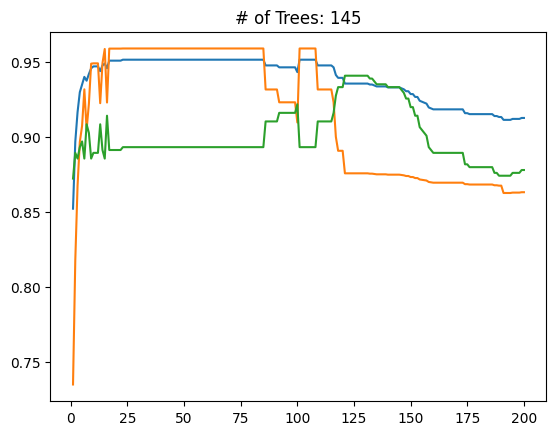

Finished iteration 1 at GAMMA: 0.005 ---- Trees = 150
Finished iteration 2 at GAMMA: 0.01 ---- Trees = 150
Finished iteration 3 at GAMMA: 0.015 ---- Trees = 150
Finished iteration 4 at GAMMA: 0.02 ---- Trees = 150
Finished iteration 5 at GAMMA: 0.025 ---- Trees = 150
Finished iteration 6 at GAMMA: 0.03 ---- Trees = 150
Finished iteration 7 at GAMMA: 0.035 ---- Trees = 150
Finished iteration 8 at GAMMA: 0.04 ---- Trees = 150
Finished iteration 9 at GAMMA: 0.045 ---- Trees = 150
Finished iteration 10 at GAMMA: 0.05 ---- Trees = 150
Finished iteration 11 at GAMMA: 0.055 ---- Trees = 150
Finished iteration 12 at GAMMA: 0.06 ---- Trees = 150
Finished iteration 13 at GAMMA: 0.065 ---- Trees = 150
Finished iteration 14 at GAMMA: 0.07 ---- Trees = 150
Finished iteration 15 at GAMMA: 0.075 ---- Trees = 150
Finished iteration 16 at GAMMA: 0.08 ---- Trees = 150
Finished iteration 17 at GAMMA: 0.085 ---- Trees = 150
Finished iteration 18 at GAMMA: 0.09 ---- Trees = 150
Finished iteration 19 at GAM

Finished iteration 147 at GAMMA: 0.735 ---- Trees = 150
Finished iteration 148 at GAMMA: 0.74 ---- Trees = 150
Finished iteration 149 at GAMMA: 0.745 ---- Trees = 150
Finished iteration 150 at GAMMA: 0.75 ---- Trees = 150
Finished iteration 151 at GAMMA: 0.755 ---- Trees = 150
Finished iteration 152 at GAMMA: 0.76 ---- Trees = 150
Finished iteration 153 at GAMMA: 0.765 ---- Trees = 150
Finished iteration 154 at GAMMA: 0.77 ---- Trees = 150
Finished iteration 155 at GAMMA: 0.775 ---- Trees = 150
Finished iteration 156 at GAMMA: 0.78 ---- Trees = 150
Finished iteration 157 at GAMMA: 0.785 ---- Trees = 150
Finished iteration 158 at GAMMA: 0.79 ---- Trees = 150
Finished iteration 159 at GAMMA: 0.795 ---- Trees = 150
Finished iteration 160 at GAMMA: 0.8 ---- Trees = 150
Finished iteration 161 at GAMMA: 0.805 ---- Trees = 150
Finished iteration 162 at GAMMA: 0.81 ---- Trees = 150
Finished iteration 163 at GAMMA: 0.8150000000000001 ---- Trees = 150
Finished iteration 164 at GAMMA: 0.820000000

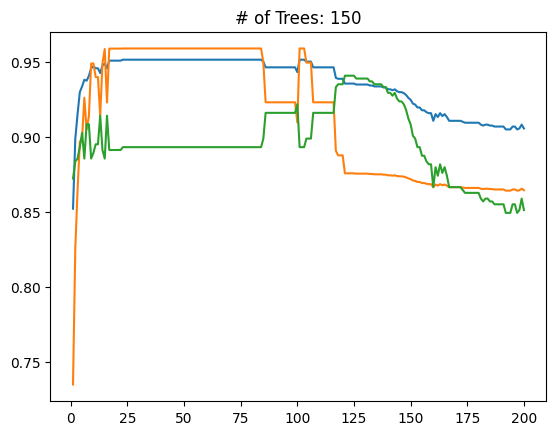

Finished iteration 1 at GAMMA: 0.005 ---- Trees = 155
Finished iteration 2 at GAMMA: 0.01 ---- Trees = 155
Finished iteration 3 at GAMMA: 0.015 ---- Trees = 155
Finished iteration 4 at GAMMA: 0.02 ---- Trees = 155
Finished iteration 5 at GAMMA: 0.025 ---- Trees = 155
Finished iteration 6 at GAMMA: 0.03 ---- Trees = 155
Finished iteration 7 at GAMMA: 0.035 ---- Trees = 155
Finished iteration 8 at GAMMA: 0.04 ---- Trees = 155
Finished iteration 9 at GAMMA: 0.045 ---- Trees = 155
Finished iteration 10 at GAMMA: 0.05 ---- Trees = 155
Finished iteration 11 at GAMMA: 0.055 ---- Trees = 155
Finished iteration 12 at GAMMA: 0.06 ---- Trees = 155
Finished iteration 13 at GAMMA: 0.065 ---- Trees = 155
Finished iteration 14 at GAMMA: 0.07 ---- Trees = 155
Finished iteration 15 at GAMMA: 0.075 ---- Trees = 155
Finished iteration 16 at GAMMA: 0.08 ---- Trees = 155
Finished iteration 17 at GAMMA: 0.085 ---- Trees = 155
Finished iteration 18 at GAMMA: 0.09 ---- Trees = 155
Finished iteration 19 at GAM

Finished iteration 147 at GAMMA: 0.735 ---- Trees = 155
Finished iteration 148 at GAMMA: 0.74 ---- Trees = 155
Finished iteration 149 at GAMMA: 0.745 ---- Trees = 155
Finished iteration 150 at GAMMA: 0.75 ---- Trees = 155
Finished iteration 151 at GAMMA: 0.755 ---- Trees = 155
Finished iteration 152 at GAMMA: 0.76 ---- Trees = 155
Finished iteration 153 at GAMMA: 0.765 ---- Trees = 155
Finished iteration 154 at GAMMA: 0.77 ---- Trees = 155
Finished iteration 155 at GAMMA: 0.775 ---- Trees = 155
Finished iteration 156 at GAMMA: 0.78 ---- Trees = 155
Finished iteration 157 at GAMMA: 0.785 ---- Trees = 155
Finished iteration 158 at GAMMA: 0.79 ---- Trees = 155
Finished iteration 159 at GAMMA: 0.795 ---- Trees = 155
Finished iteration 160 at GAMMA: 0.8 ---- Trees = 155
Finished iteration 161 at GAMMA: 0.805 ---- Trees = 155
Finished iteration 162 at GAMMA: 0.81 ---- Trees = 155
Finished iteration 163 at GAMMA: 0.8150000000000001 ---- Trees = 155
Finished iteration 164 at GAMMA: 0.820000000

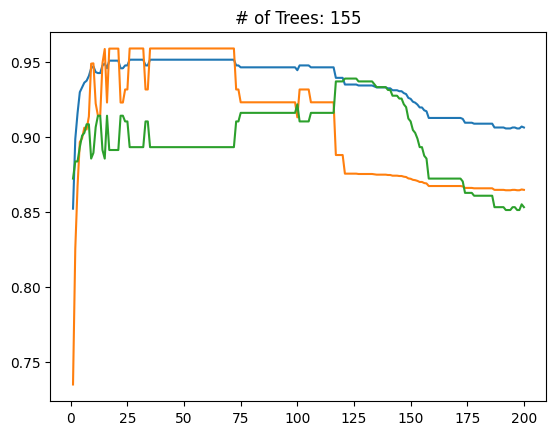

Finished iteration 1 at GAMMA: 0.005 ---- Trees = 160
Finished iteration 2 at GAMMA: 0.01 ---- Trees = 160
Finished iteration 3 at GAMMA: 0.015 ---- Trees = 160
Finished iteration 4 at GAMMA: 0.02 ---- Trees = 160
Finished iteration 5 at GAMMA: 0.025 ---- Trees = 160
Finished iteration 6 at GAMMA: 0.03 ---- Trees = 160
Finished iteration 7 at GAMMA: 0.035 ---- Trees = 160
Finished iteration 8 at GAMMA: 0.04 ---- Trees = 160
Finished iteration 9 at GAMMA: 0.045 ---- Trees = 160
Finished iteration 10 at GAMMA: 0.05 ---- Trees = 160
Finished iteration 11 at GAMMA: 0.055 ---- Trees = 160
Finished iteration 12 at GAMMA: 0.06 ---- Trees = 160
Finished iteration 13 at GAMMA: 0.065 ---- Trees = 160
Finished iteration 14 at GAMMA: 0.07 ---- Trees = 160
Finished iteration 15 at GAMMA: 0.075 ---- Trees = 160
Finished iteration 16 at GAMMA: 0.08 ---- Trees = 160
Finished iteration 17 at GAMMA: 0.085 ---- Trees = 160
Finished iteration 18 at GAMMA: 0.09 ---- Trees = 160
Finished iteration 19 at GAM

Finished iteration 147 at GAMMA: 0.735 ---- Trees = 160
Finished iteration 148 at GAMMA: 0.74 ---- Trees = 160
Finished iteration 149 at GAMMA: 0.745 ---- Trees = 160
Finished iteration 150 at GAMMA: 0.75 ---- Trees = 160
Finished iteration 151 at GAMMA: 0.755 ---- Trees = 160
Finished iteration 152 at GAMMA: 0.76 ---- Trees = 160
Finished iteration 153 at GAMMA: 0.765 ---- Trees = 160
Finished iteration 154 at GAMMA: 0.77 ---- Trees = 160
Finished iteration 155 at GAMMA: 0.775 ---- Trees = 160
Finished iteration 156 at GAMMA: 0.78 ---- Trees = 160
Finished iteration 157 at GAMMA: 0.785 ---- Trees = 160
Finished iteration 158 at GAMMA: 0.79 ---- Trees = 160
Finished iteration 159 at GAMMA: 0.795 ---- Trees = 160
Finished iteration 160 at GAMMA: 0.8 ---- Trees = 160
Finished iteration 161 at GAMMA: 0.805 ---- Trees = 160
Finished iteration 162 at GAMMA: 0.81 ---- Trees = 160
Finished iteration 163 at GAMMA: 0.8150000000000001 ---- Trees = 160
Finished iteration 164 at GAMMA: 0.820000000

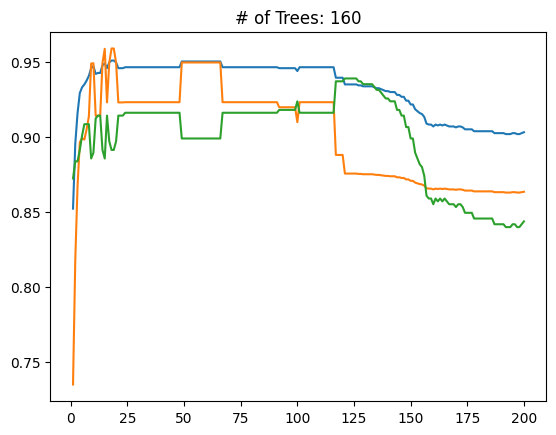

Finished iteration 1 at GAMMA: 0.005 ---- Trees = 165
Finished iteration 2 at GAMMA: 0.01 ---- Trees = 165
Finished iteration 3 at GAMMA: 0.015 ---- Trees = 165
Finished iteration 4 at GAMMA: 0.02 ---- Trees = 165
Finished iteration 5 at GAMMA: 0.025 ---- Trees = 165
Finished iteration 6 at GAMMA: 0.03 ---- Trees = 165
Finished iteration 7 at GAMMA: 0.035 ---- Trees = 165
Finished iteration 8 at GAMMA: 0.04 ---- Trees = 165
Finished iteration 9 at GAMMA: 0.045 ---- Trees = 165
Finished iteration 10 at GAMMA: 0.05 ---- Trees = 165
Finished iteration 11 at GAMMA: 0.055 ---- Trees = 165
Finished iteration 12 at GAMMA: 0.06 ---- Trees = 165
Finished iteration 13 at GAMMA: 0.065 ---- Trees = 165
Finished iteration 14 at GAMMA: 0.07 ---- Trees = 165
Finished iteration 15 at GAMMA: 0.075 ---- Trees = 165
Finished iteration 16 at GAMMA: 0.08 ---- Trees = 165
Finished iteration 17 at GAMMA: 0.085 ---- Trees = 165
Finished iteration 18 at GAMMA: 0.09 ---- Trees = 165
Finished iteration 19 at GAM

Finished iteration 147 at GAMMA: 0.735 ---- Trees = 165
Finished iteration 148 at GAMMA: 0.74 ---- Trees = 165
Finished iteration 149 at GAMMA: 0.745 ---- Trees = 165
Finished iteration 150 at GAMMA: 0.75 ---- Trees = 165
Finished iteration 151 at GAMMA: 0.755 ---- Trees = 165
Finished iteration 152 at GAMMA: 0.76 ---- Trees = 165
Finished iteration 153 at GAMMA: 0.765 ---- Trees = 165
Finished iteration 154 at GAMMA: 0.77 ---- Trees = 165
Finished iteration 155 at GAMMA: 0.775 ---- Trees = 165
Finished iteration 156 at GAMMA: 0.78 ---- Trees = 165
Finished iteration 157 at GAMMA: 0.785 ---- Trees = 165
Finished iteration 158 at GAMMA: 0.79 ---- Trees = 165
Finished iteration 159 at GAMMA: 0.795 ---- Trees = 165
Finished iteration 160 at GAMMA: 0.8 ---- Trees = 165
Finished iteration 161 at GAMMA: 0.805 ---- Trees = 165
Finished iteration 162 at GAMMA: 0.81 ---- Trees = 165
Finished iteration 163 at GAMMA: 0.8150000000000001 ---- Trees = 165
Finished iteration 164 at GAMMA: 0.820000000

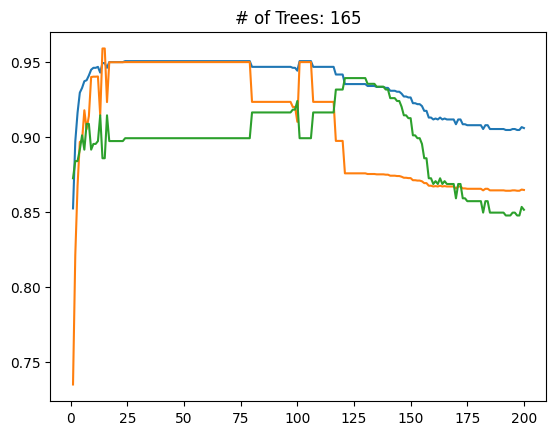

Finished iteration 1 at GAMMA: 0.005 ---- Trees = 170
Finished iteration 2 at GAMMA: 0.01 ---- Trees = 170
Finished iteration 3 at GAMMA: 0.015 ---- Trees = 170
Finished iteration 4 at GAMMA: 0.02 ---- Trees = 170
Finished iteration 5 at GAMMA: 0.025 ---- Trees = 170
Finished iteration 6 at GAMMA: 0.03 ---- Trees = 170
Finished iteration 7 at GAMMA: 0.035 ---- Trees = 170
Finished iteration 8 at GAMMA: 0.04 ---- Trees = 170
Finished iteration 9 at GAMMA: 0.045 ---- Trees = 170
Finished iteration 10 at GAMMA: 0.05 ---- Trees = 170
Finished iteration 11 at GAMMA: 0.055 ---- Trees = 170
Finished iteration 12 at GAMMA: 0.06 ---- Trees = 170
Finished iteration 13 at GAMMA: 0.065 ---- Trees = 170
Finished iteration 14 at GAMMA: 0.07 ---- Trees = 170
Finished iteration 15 at GAMMA: 0.075 ---- Trees = 170
Finished iteration 16 at GAMMA: 0.08 ---- Trees = 170
Finished iteration 17 at GAMMA: 0.085 ---- Trees = 170
Finished iteration 18 at GAMMA: 0.09 ---- Trees = 170
Finished iteration 19 at GAM

Finished iteration 147 at GAMMA: 0.735 ---- Trees = 170
Finished iteration 148 at GAMMA: 0.74 ---- Trees = 170
Finished iteration 149 at GAMMA: 0.745 ---- Trees = 170
Finished iteration 150 at GAMMA: 0.75 ---- Trees = 170
Finished iteration 151 at GAMMA: 0.755 ---- Trees = 170
Finished iteration 152 at GAMMA: 0.76 ---- Trees = 170
Finished iteration 153 at GAMMA: 0.765 ---- Trees = 170
Finished iteration 154 at GAMMA: 0.77 ---- Trees = 170
Finished iteration 155 at GAMMA: 0.775 ---- Trees = 170
Finished iteration 156 at GAMMA: 0.78 ---- Trees = 170
Finished iteration 157 at GAMMA: 0.785 ---- Trees = 170
Finished iteration 158 at GAMMA: 0.79 ---- Trees = 170
Finished iteration 159 at GAMMA: 0.795 ---- Trees = 170
Finished iteration 160 at GAMMA: 0.8 ---- Trees = 170
Finished iteration 161 at GAMMA: 0.805 ---- Trees = 170
Finished iteration 162 at GAMMA: 0.81 ---- Trees = 170
Finished iteration 163 at GAMMA: 0.8150000000000001 ---- Trees = 170
Finished iteration 164 at GAMMA: 0.820000000

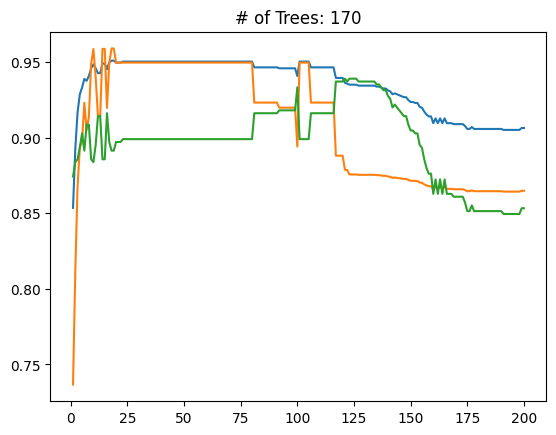

Finished iteration 1 at GAMMA: 0.005 ---- Trees = 175
Finished iteration 2 at GAMMA: 0.01 ---- Trees = 175
Finished iteration 3 at GAMMA: 0.015 ---- Trees = 175
Finished iteration 4 at GAMMA: 0.02 ---- Trees = 175
Finished iteration 5 at GAMMA: 0.025 ---- Trees = 175
Finished iteration 6 at GAMMA: 0.03 ---- Trees = 175
Finished iteration 7 at GAMMA: 0.035 ---- Trees = 175
Finished iteration 8 at GAMMA: 0.04 ---- Trees = 175
Finished iteration 9 at GAMMA: 0.045 ---- Trees = 175
Finished iteration 10 at GAMMA: 0.05 ---- Trees = 175
Finished iteration 11 at GAMMA: 0.055 ---- Trees = 175
Finished iteration 12 at GAMMA: 0.06 ---- Trees = 175
Finished iteration 13 at GAMMA: 0.065 ---- Trees = 175
Finished iteration 14 at GAMMA: 0.07 ---- Trees = 175
Finished iteration 15 at GAMMA: 0.075 ---- Trees = 175
Finished iteration 16 at GAMMA: 0.08 ---- Trees = 175
Finished iteration 17 at GAMMA: 0.085 ---- Trees = 175
Finished iteration 18 at GAMMA: 0.09 ---- Trees = 175
Finished iteration 19 at GAM

Finished iteration 147 at GAMMA: 0.735 ---- Trees = 175
Finished iteration 148 at GAMMA: 0.74 ---- Trees = 175
Finished iteration 149 at GAMMA: 0.745 ---- Trees = 175
Finished iteration 150 at GAMMA: 0.75 ---- Trees = 175
Finished iteration 151 at GAMMA: 0.755 ---- Trees = 175
Finished iteration 152 at GAMMA: 0.76 ---- Trees = 175
Finished iteration 153 at GAMMA: 0.765 ---- Trees = 175
Finished iteration 154 at GAMMA: 0.77 ---- Trees = 175
Finished iteration 155 at GAMMA: 0.775 ---- Trees = 175
Finished iteration 156 at GAMMA: 0.78 ---- Trees = 175
Finished iteration 157 at GAMMA: 0.785 ---- Trees = 175
Finished iteration 158 at GAMMA: 0.79 ---- Trees = 175
Finished iteration 159 at GAMMA: 0.795 ---- Trees = 175
Finished iteration 160 at GAMMA: 0.8 ---- Trees = 175
Finished iteration 161 at GAMMA: 0.805 ---- Trees = 175
Finished iteration 162 at GAMMA: 0.81 ---- Trees = 175
Finished iteration 163 at GAMMA: 0.8150000000000001 ---- Trees = 175
Finished iteration 164 at GAMMA: 0.820000000

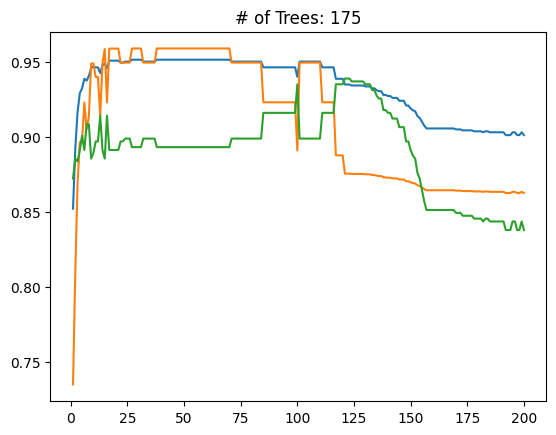

Finished iteration 1 at GAMMA: 0.005 ---- Trees = 180
Finished iteration 2 at GAMMA: 0.01 ---- Trees = 180
Finished iteration 3 at GAMMA: 0.015 ---- Trees = 180
Finished iteration 4 at GAMMA: 0.02 ---- Trees = 180
Finished iteration 5 at GAMMA: 0.025 ---- Trees = 180
Finished iteration 6 at GAMMA: 0.03 ---- Trees = 180
Finished iteration 7 at GAMMA: 0.035 ---- Trees = 180
Finished iteration 8 at GAMMA: 0.04 ---- Trees = 180
Finished iteration 9 at GAMMA: 0.045 ---- Trees = 180
Finished iteration 10 at GAMMA: 0.05 ---- Trees = 180
Finished iteration 11 at GAMMA: 0.055 ---- Trees = 180
Finished iteration 12 at GAMMA: 0.06 ---- Trees = 180
Finished iteration 13 at GAMMA: 0.065 ---- Trees = 180
Finished iteration 14 at GAMMA: 0.07 ---- Trees = 180
Finished iteration 15 at GAMMA: 0.075 ---- Trees = 180
Finished iteration 16 at GAMMA: 0.08 ---- Trees = 180
Finished iteration 17 at GAMMA: 0.085 ---- Trees = 180
Finished iteration 18 at GAMMA: 0.09 ---- Trees = 180
Finished iteration 19 at GAM

Finished iteration 147 at GAMMA: 0.735 ---- Trees = 180
Finished iteration 148 at GAMMA: 0.74 ---- Trees = 180
Finished iteration 149 at GAMMA: 0.745 ---- Trees = 180
Finished iteration 150 at GAMMA: 0.75 ---- Trees = 180
Finished iteration 151 at GAMMA: 0.755 ---- Trees = 180
Finished iteration 152 at GAMMA: 0.76 ---- Trees = 180
Finished iteration 153 at GAMMA: 0.765 ---- Trees = 180
Finished iteration 154 at GAMMA: 0.77 ---- Trees = 180
Finished iteration 155 at GAMMA: 0.775 ---- Trees = 180
Finished iteration 156 at GAMMA: 0.78 ---- Trees = 180
Finished iteration 157 at GAMMA: 0.785 ---- Trees = 180
Finished iteration 158 at GAMMA: 0.79 ---- Trees = 180
Finished iteration 159 at GAMMA: 0.795 ---- Trees = 180
Finished iteration 160 at GAMMA: 0.8 ---- Trees = 180
Finished iteration 161 at GAMMA: 0.805 ---- Trees = 180
Finished iteration 162 at GAMMA: 0.81 ---- Trees = 180
Finished iteration 163 at GAMMA: 0.8150000000000001 ---- Trees = 180
Finished iteration 164 at GAMMA: 0.820000000

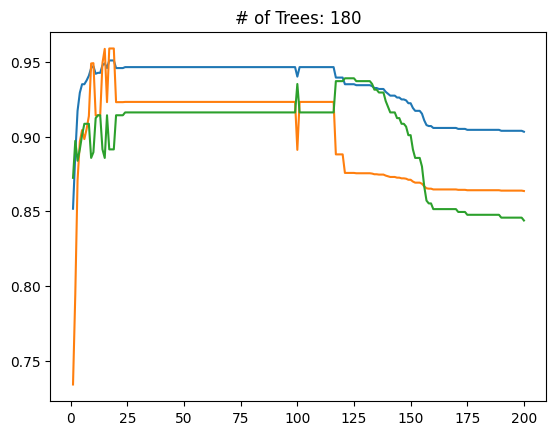

Finished iteration 1 at GAMMA: 0.005 ---- Trees = 185
Finished iteration 2 at GAMMA: 0.01 ---- Trees = 185
Finished iteration 3 at GAMMA: 0.015 ---- Trees = 185
Finished iteration 4 at GAMMA: 0.02 ---- Trees = 185
Finished iteration 5 at GAMMA: 0.025 ---- Trees = 185
Finished iteration 6 at GAMMA: 0.03 ---- Trees = 185
Finished iteration 7 at GAMMA: 0.035 ---- Trees = 185
Finished iteration 8 at GAMMA: 0.04 ---- Trees = 185
Finished iteration 9 at GAMMA: 0.045 ---- Trees = 185
Finished iteration 10 at GAMMA: 0.05 ---- Trees = 185
Finished iteration 11 at GAMMA: 0.055 ---- Trees = 185
Finished iteration 12 at GAMMA: 0.06 ---- Trees = 185
Finished iteration 13 at GAMMA: 0.065 ---- Trees = 185
Finished iteration 14 at GAMMA: 0.07 ---- Trees = 185
Finished iteration 15 at GAMMA: 0.075 ---- Trees = 185
Finished iteration 16 at GAMMA: 0.08 ---- Trees = 185
Finished iteration 17 at GAMMA: 0.085 ---- Trees = 185
Finished iteration 18 at GAMMA: 0.09 ---- Trees = 185
Finished iteration 19 at GAM

Finished iteration 147 at GAMMA: 0.735 ---- Trees = 185
Finished iteration 148 at GAMMA: 0.74 ---- Trees = 185
Finished iteration 149 at GAMMA: 0.745 ---- Trees = 185
Finished iteration 150 at GAMMA: 0.75 ---- Trees = 185
Finished iteration 151 at GAMMA: 0.755 ---- Trees = 185
Finished iteration 152 at GAMMA: 0.76 ---- Trees = 185
Finished iteration 153 at GAMMA: 0.765 ---- Trees = 185
Finished iteration 154 at GAMMA: 0.77 ---- Trees = 185
Finished iteration 155 at GAMMA: 0.775 ---- Trees = 185
Finished iteration 156 at GAMMA: 0.78 ---- Trees = 185
Finished iteration 157 at GAMMA: 0.785 ---- Trees = 185
Finished iteration 158 at GAMMA: 0.79 ---- Trees = 185
Finished iteration 159 at GAMMA: 0.795 ---- Trees = 185
Finished iteration 160 at GAMMA: 0.8 ---- Trees = 185
Finished iteration 161 at GAMMA: 0.805 ---- Trees = 185
Finished iteration 162 at GAMMA: 0.81 ---- Trees = 185
Finished iteration 163 at GAMMA: 0.8150000000000001 ---- Trees = 185
Finished iteration 164 at GAMMA: 0.820000000

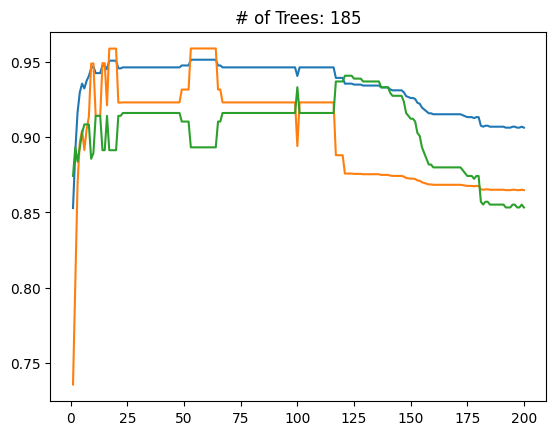

Finished iteration 1 at GAMMA: 0.005 ---- Trees = 190
Finished iteration 2 at GAMMA: 0.01 ---- Trees = 190
Finished iteration 3 at GAMMA: 0.015 ---- Trees = 190
Finished iteration 4 at GAMMA: 0.02 ---- Trees = 190
Finished iteration 5 at GAMMA: 0.025 ---- Trees = 190
Finished iteration 6 at GAMMA: 0.03 ---- Trees = 190
Finished iteration 7 at GAMMA: 0.035 ---- Trees = 190
Finished iteration 8 at GAMMA: 0.04 ---- Trees = 190
Finished iteration 9 at GAMMA: 0.045 ---- Trees = 190
Finished iteration 10 at GAMMA: 0.05 ---- Trees = 190
Finished iteration 11 at GAMMA: 0.055 ---- Trees = 190
Finished iteration 12 at GAMMA: 0.06 ---- Trees = 190
Finished iteration 13 at GAMMA: 0.065 ---- Trees = 190
Finished iteration 14 at GAMMA: 0.07 ---- Trees = 190
Finished iteration 15 at GAMMA: 0.075 ---- Trees = 190
Finished iteration 16 at GAMMA: 0.08 ---- Trees = 190
Finished iteration 17 at GAMMA: 0.085 ---- Trees = 190
Finished iteration 18 at GAMMA: 0.09 ---- Trees = 190
Finished iteration 19 at GAM

Finished iteration 147 at GAMMA: 0.735 ---- Trees = 190
Finished iteration 148 at GAMMA: 0.74 ---- Trees = 190
Finished iteration 149 at GAMMA: 0.745 ---- Trees = 190
Finished iteration 150 at GAMMA: 0.75 ---- Trees = 190
Finished iteration 151 at GAMMA: 0.755 ---- Trees = 190
Finished iteration 152 at GAMMA: 0.76 ---- Trees = 190
Finished iteration 153 at GAMMA: 0.765 ---- Trees = 190
Finished iteration 154 at GAMMA: 0.77 ---- Trees = 190
Finished iteration 155 at GAMMA: 0.775 ---- Trees = 190
Finished iteration 156 at GAMMA: 0.78 ---- Trees = 190
Finished iteration 157 at GAMMA: 0.785 ---- Trees = 190
Finished iteration 158 at GAMMA: 0.79 ---- Trees = 190
Finished iteration 159 at GAMMA: 0.795 ---- Trees = 190
Finished iteration 160 at GAMMA: 0.8 ---- Trees = 190
Finished iteration 161 at GAMMA: 0.805 ---- Trees = 190
Finished iteration 162 at GAMMA: 0.81 ---- Trees = 190
Finished iteration 163 at GAMMA: 0.8150000000000001 ---- Trees = 190
Finished iteration 164 at GAMMA: 0.820000000

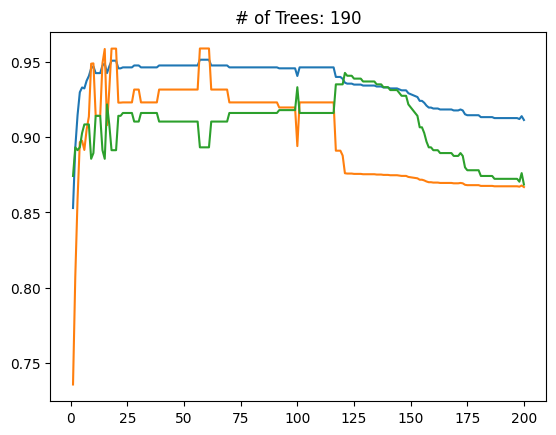

Finished iteration 1 at GAMMA: 0.005 ---- Trees = 195
Finished iteration 2 at GAMMA: 0.01 ---- Trees = 195
Finished iteration 3 at GAMMA: 0.015 ---- Trees = 195
Finished iteration 4 at GAMMA: 0.02 ---- Trees = 195
Finished iteration 5 at GAMMA: 0.025 ---- Trees = 195
Finished iteration 6 at GAMMA: 0.03 ---- Trees = 195
Finished iteration 7 at GAMMA: 0.035 ---- Trees = 195
Finished iteration 8 at GAMMA: 0.04 ---- Trees = 195
Finished iteration 9 at GAMMA: 0.045 ---- Trees = 195
Finished iteration 10 at GAMMA: 0.05 ---- Trees = 195
Finished iteration 11 at GAMMA: 0.055 ---- Trees = 195
Finished iteration 12 at GAMMA: 0.06 ---- Trees = 195
Finished iteration 13 at GAMMA: 0.065 ---- Trees = 195
Finished iteration 14 at GAMMA: 0.07 ---- Trees = 195
Finished iteration 15 at GAMMA: 0.075 ---- Trees = 195
Finished iteration 16 at GAMMA: 0.08 ---- Trees = 195
Finished iteration 17 at GAMMA: 0.085 ---- Trees = 195
Finished iteration 18 at GAMMA: 0.09 ---- Trees = 195
Finished iteration 19 at GAM

Finished iteration 147 at GAMMA: 0.735 ---- Trees = 195
Finished iteration 148 at GAMMA: 0.74 ---- Trees = 195
Finished iteration 149 at GAMMA: 0.745 ---- Trees = 195
Finished iteration 150 at GAMMA: 0.75 ---- Trees = 195
Finished iteration 151 at GAMMA: 0.755 ---- Trees = 195
Finished iteration 152 at GAMMA: 0.76 ---- Trees = 195
Finished iteration 153 at GAMMA: 0.765 ---- Trees = 195
Finished iteration 154 at GAMMA: 0.77 ---- Trees = 195
Finished iteration 155 at GAMMA: 0.775 ---- Trees = 195
Finished iteration 156 at GAMMA: 0.78 ---- Trees = 195
Finished iteration 157 at GAMMA: 0.785 ---- Trees = 195
Finished iteration 158 at GAMMA: 0.79 ---- Trees = 195
Finished iteration 159 at GAMMA: 0.795 ---- Trees = 195
Finished iteration 160 at GAMMA: 0.8 ---- Trees = 195
Finished iteration 161 at GAMMA: 0.805 ---- Trees = 195
Finished iteration 162 at GAMMA: 0.81 ---- Trees = 195
Finished iteration 163 at GAMMA: 0.8150000000000001 ---- Trees = 195
Finished iteration 164 at GAMMA: 0.820000000

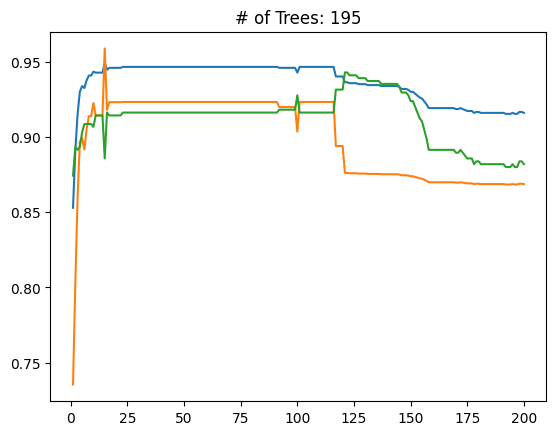

Finished iteration 1 at GAMMA: 0.005 ---- Trees = 200
Finished iteration 2 at GAMMA: 0.01 ---- Trees = 200
Finished iteration 3 at GAMMA: 0.015 ---- Trees = 200
Finished iteration 4 at GAMMA: 0.02 ---- Trees = 200
Finished iteration 5 at GAMMA: 0.025 ---- Trees = 200
Finished iteration 6 at GAMMA: 0.03 ---- Trees = 200
Finished iteration 7 at GAMMA: 0.035 ---- Trees = 200
Finished iteration 8 at GAMMA: 0.04 ---- Trees = 200
Finished iteration 9 at GAMMA: 0.045 ---- Trees = 200
Finished iteration 10 at GAMMA: 0.05 ---- Trees = 200
Finished iteration 11 at GAMMA: 0.055 ---- Trees = 200
Finished iteration 12 at GAMMA: 0.06 ---- Trees = 200
Finished iteration 13 at GAMMA: 0.065 ---- Trees = 200
Finished iteration 14 at GAMMA: 0.07 ---- Trees = 200
Finished iteration 15 at GAMMA: 0.075 ---- Trees = 200
Finished iteration 16 at GAMMA: 0.08 ---- Trees = 200
Finished iteration 17 at GAMMA: 0.085 ---- Trees = 200
Finished iteration 18 at GAMMA: 0.09 ---- Trees = 200
Finished iteration 19 at GAM

Finished iteration 147 at GAMMA: 0.735 ---- Trees = 200
Finished iteration 148 at GAMMA: 0.74 ---- Trees = 200
Finished iteration 149 at GAMMA: 0.745 ---- Trees = 200
Finished iteration 150 at GAMMA: 0.75 ---- Trees = 200
Finished iteration 151 at GAMMA: 0.755 ---- Trees = 200
Finished iteration 152 at GAMMA: 0.76 ---- Trees = 200
Finished iteration 153 at GAMMA: 0.765 ---- Trees = 200
Finished iteration 154 at GAMMA: 0.77 ---- Trees = 200
Finished iteration 155 at GAMMA: 0.775 ---- Trees = 200
Finished iteration 156 at GAMMA: 0.78 ---- Trees = 200
Finished iteration 157 at GAMMA: 0.785 ---- Trees = 200
Finished iteration 158 at GAMMA: 0.79 ---- Trees = 200
Finished iteration 159 at GAMMA: 0.795 ---- Trees = 200
Finished iteration 160 at GAMMA: 0.8 ---- Trees = 200
Finished iteration 161 at GAMMA: 0.805 ---- Trees = 200
Finished iteration 162 at GAMMA: 0.81 ---- Trees = 200
Finished iteration 163 at GAMMA: 0.8150000000000001 ---- Trees = 200
Finished iteration 164 at GAMMA: 0.820000000

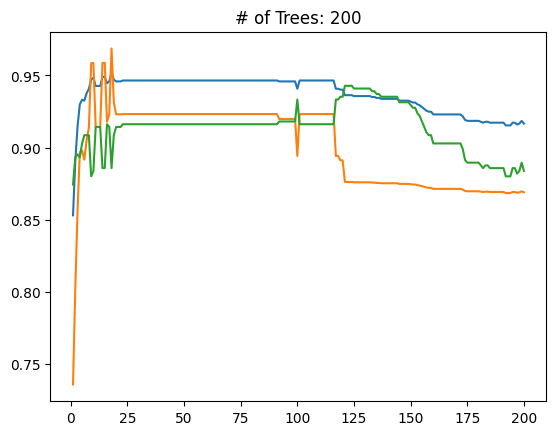

<Figure size 640x480 with 0 Axes>

In [54]:
### Loop over and determine the most optimal number for random forest !!! 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
res_container = []
cnt=0
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV
for q in range(40):
    res_container = []
    cnt=0
    for i in range(200):
        np.random.seed(8675309)
        cnt+=1

        base_classifier1 = SVC(kernel="poly", gamma=0.005*(i+1), probability=True) 
        base_classifier2 = RandomForestClassifier(n_estimators=(q+1)*5)    
        base_classifier3 = GaussianNB()

        res1 = SelfTrainingClassifier(base_classifier1,max_iter=None).fit(z,y) #TRAINING ON TRAINING SET
        res2 = SelfTrainingClassifier(base_classifier2,max_iter=None).fit(z,y) #NON-CALIBRATED
        res3 = SelfTrainingClassifier(base_classifier3,max_iter=None).fit(z,y)

        res_out = np.round((res1.predict_proba(z)+res2.predict_proba(z)+res3.predict_proba(z))/3) #TRAIN            ###NON-CALIBRATED
        res_out2 = np.round((res1.predict_proba(z2)+res2.predict_proba(z2)+res3.predict_proba(z2))/3) #VALID
        res_out3 = np.round((res1.predict_proba(z3)+res2.predict_proba(z3)+res3.predict_proba(z3))/3) #TEST
        list_one,list_two,list_three = [],[],[]

        for ele in res_out:
            if ele[0] == 1:
                list_one.append(0)
            else:
                list_one.append(1)
        for ele in res_out2:
            if ele[0] == 1:
                list_two.append(0)
            else:
                list_two.append(1)
        for ele in res_out3:
            if ele[0] == 1:
                list_three.append(0)
            else:
                list_three.append(1)

        dataframe = pd.read_csv("Quality_Check.csv")           #TOTAL ACCURACY OF TRAINING + VALIDATION SET + TEST PREDICTIONS
        dataframe_labelsE=dataframe.filter(regex="Label_[0-9]E").dropna(0,"all")
        dataframe_labelsP=dataframe.filter(regex="Label_[0-9]P").dropna(0,"all")

        #Redefine dataframe to results generated for testing quality score improvements
        dataframe["Label_3P"],dataframe["Label_4P"],dataframe["Label_5P"],dataframe["Label_7P"] = list_one[0:203],list_one[203:406],list_one[406:609],list_one[609:]
        dataframe["Label_2P"],dataframe["Label_6P"],dataframe["Label_8P"] = list_two[0:203],list_two[203:406],list_two[406:]
        dataframe["Label_1P"],dataframe["Label_9P"] =list_three[0:203],list_three[203:]

        tp, tn, fp, fn, wrong, right = 0, 0, 0, 0, 0, 0
        for col in dataframe_labelsE:
            #if col in ["Label_5E","Label_6E"]:
            #    continue
            for i in range(len(dataframe_labelsE["Label_1E"])):
                if dataframe[col][i] == -1:
                    continue
                elif dataframe[col][i] == dataframe[col.replace("E","P")][i]:
                    if dataframe[col][i] == 1:
                        tp+=1
                        right+=1
                    elif dataframe[col][i] == 0:
                        tn+=1
                        right+=1
                else:
                    if dataframe[col][i]==1:
                        fn+=1
                        wrong+=1
                    else:
                        fp+=1
                        wrong+=1

        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        accuracy = right/(right+wrong)
        bundle = [accuracy,precision,recall]
        res_container.append(bundle)
        print("Finished iteration "+str(cnt)+" at GAMMA: "+str(base_classifier1.gamma)+" ---- Trees = "+str(base_classifier2.n_estimators))
    x = range(1,201)
    plt.title("# of Trees: "+str(base_classifier2.n_estimators))
    plt.plot(x,res_container)
    plt.show()
    plt.savefig(str(base_classifier2.n_estimators)+".pdf")

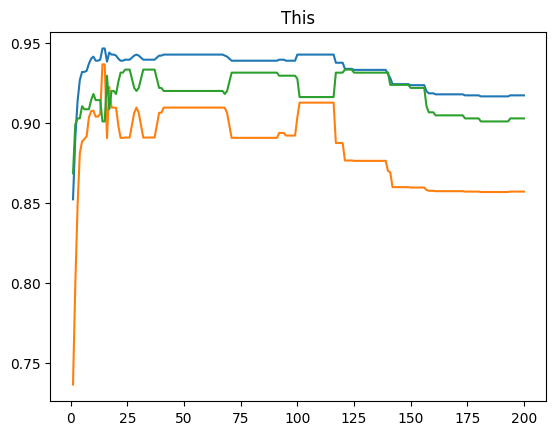

In [52]:
import matplotlib.pyplot as plt
x = range(1,201)
plt.title("# of Trees: "+str(base_classifier2.n_estimators))
plt.plot(x,res_container)
plt.show()
plt.savefig(str(base_classifier2.n_estimators)+".pdf")

In [48]:
res_container[9:25]

[[0.9414385741565882, 0.9077212806026366, 0.9180952380952381],
 [0.9388924252068745, 0.903954802259887, 0.9142857142857143],
 [0.9388924252068745, 0.903954802259887, 0.9142857142857143],
 [0.939528962444303, 0.9056603773584906, 0.9142857142857143],
 [0.9465308720560153, 0.9366336633663367, 0.900952380952381],
 [0.9465308720560153, 0.9366336633663367, 0.900952380952381],
 [0.9382558879694463, 0.8905109489051095, 0.9295238095238095],
 [0.9439847231063018, 0.9226305609284333, 0.9085714285714286],
 [0.942711648631445, 0.9096045197740112, 0.92],
 [0.942711648631445, 0.9096045197740112, 0.92],
 [0.9420751113940166, 0.909433962264151, 0.9180952380952381],
 [0.9401654996817314, 0.8983364140480592, 0.9257142857142857],
 [0.9388924252068745, 0.8907103825136612, 0.9314285714285714],
 [0.9388924252068745, 0.8907103825136612, 0.9314285714285714],
 [0.939528962444303, 0.8909090909090909, 0.9333333333333333],
 [0.939528962444303, 0.8909090909090909, 0.9333333333333333]]